In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'
from setup import *

# Computations

## A priori vs Steady state

In [3]:
Diffs = []
for temp in TEMPS:
    X = load_sequences(bDATAPATH, temp)
    bouts_mc = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    Pb = MC.bout_proba(bouts_mc)
    Std = MC.steady_state(MC.bout_transitions(bouts_mc))
    Diffs.append(np.abs(Pb - Std))

In [4]:
f"Max diff between bout probability and steady state ; {np.array(Diffs).max():0.4f}"

'Max diff between bout probability and steady state ; 0.0028'

# Figure

## Example trajectory labeling

In [9]:
from matplotlib.markers import MarkerStyle

In [6]:
temp = 22
i = 382
angles, xpos, ypos = load_full_traj(bDATAPATH, temp, i)
t = np.arange(len(angles))
bouts = MC.threshold_classifier([angles], -DTHETA_THRESH, +DTHETA_THRESH)[0]
bouts_hmm = load_viterbi(bMODELPATH, "g3", temp)[i]

In [7]:
start, stop = 24, 75

Text(0, 0.5, '$\\delta\\theta_n$ (°)')

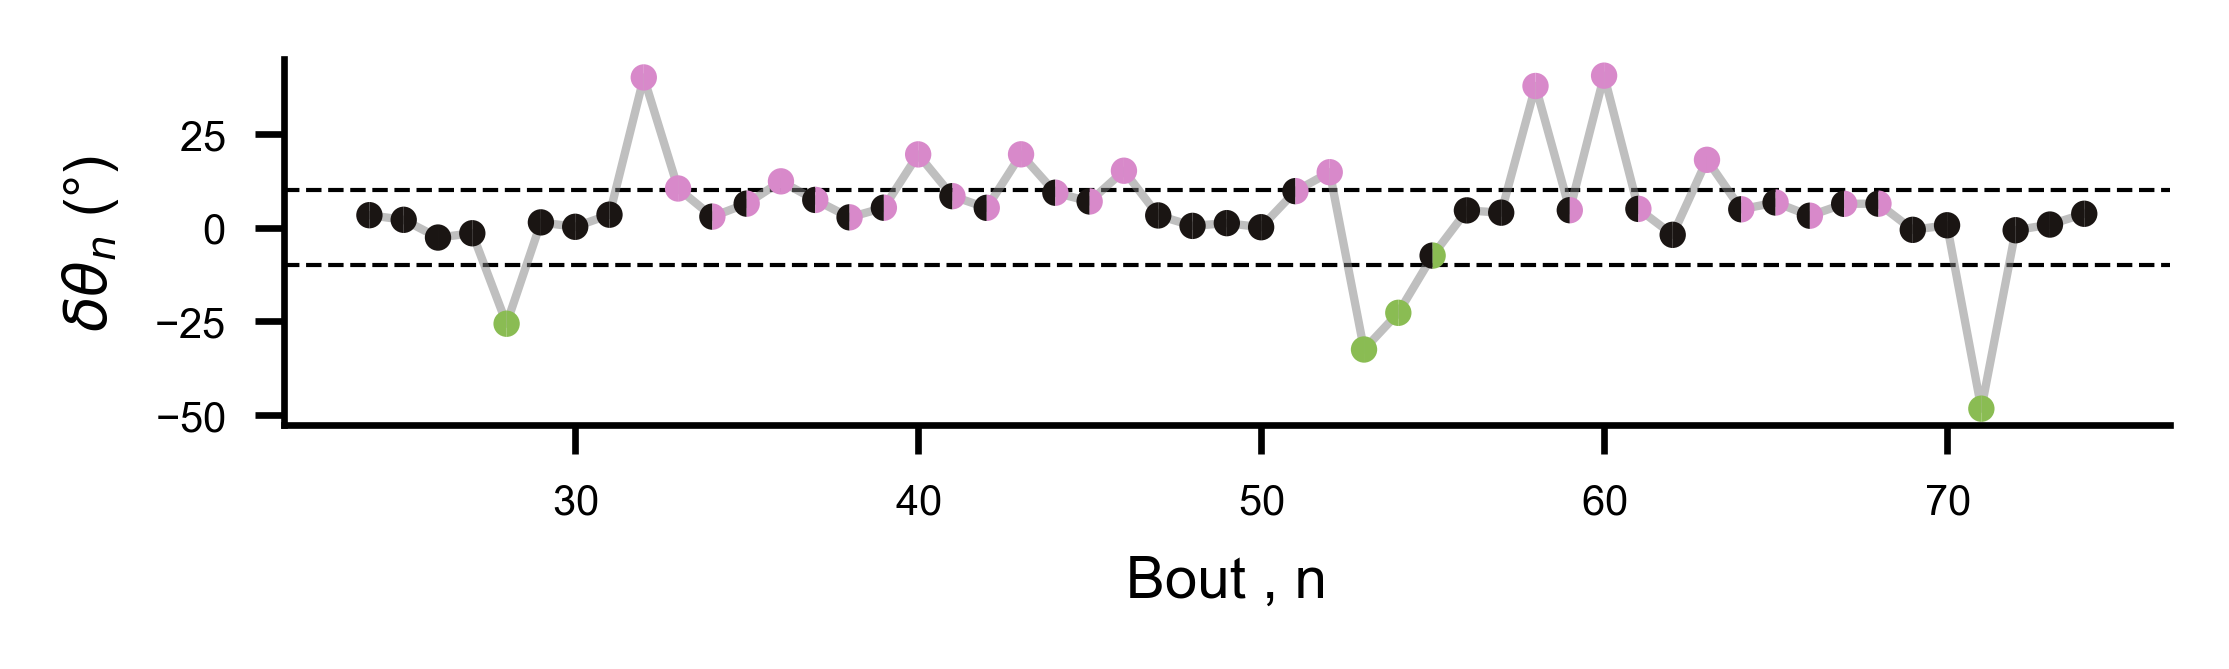

In [10]:
fig, ax = plt.subplots(figsize=(1.8*2,1))

ax.plot(
    t[start:stop], angles[start:stop], 
    zorder=1, 
    color="grey", linewidth=1, alpha=0.5
)
ax.scatter(
    t[start:stop], angles[start:stop], 
    c=FLR_colors[bouts[start:stop]], 
    s=10,
    zorder=2, marker=MarkerStyle("o", fillstyle="left"), linewidth=0
)
ax.scatter(
    t[start:stop], angles[start:stop], 
    c=FLR_colors[bouts_hmm[start:stop]], 
    s=10,
    zorder=3, marker=MarkerStyle("o", fillstyle="right"), linewidth=0
)
ax.axhline(+10, zorder=0, linewidth=0.5, linestyle="--")
ax.axhline(-10, zorder=0, linewidth=0.5, linestyle="--")
ax.set_xlabel("Bout , n")
ax.set_ylabel(r"$\delta\theta_n$ (°)")

#fig.savefig(f"panels/Fig2/example_labeling_part1.svg")

Text(71.28460999999999, 27.18643, '4mm')

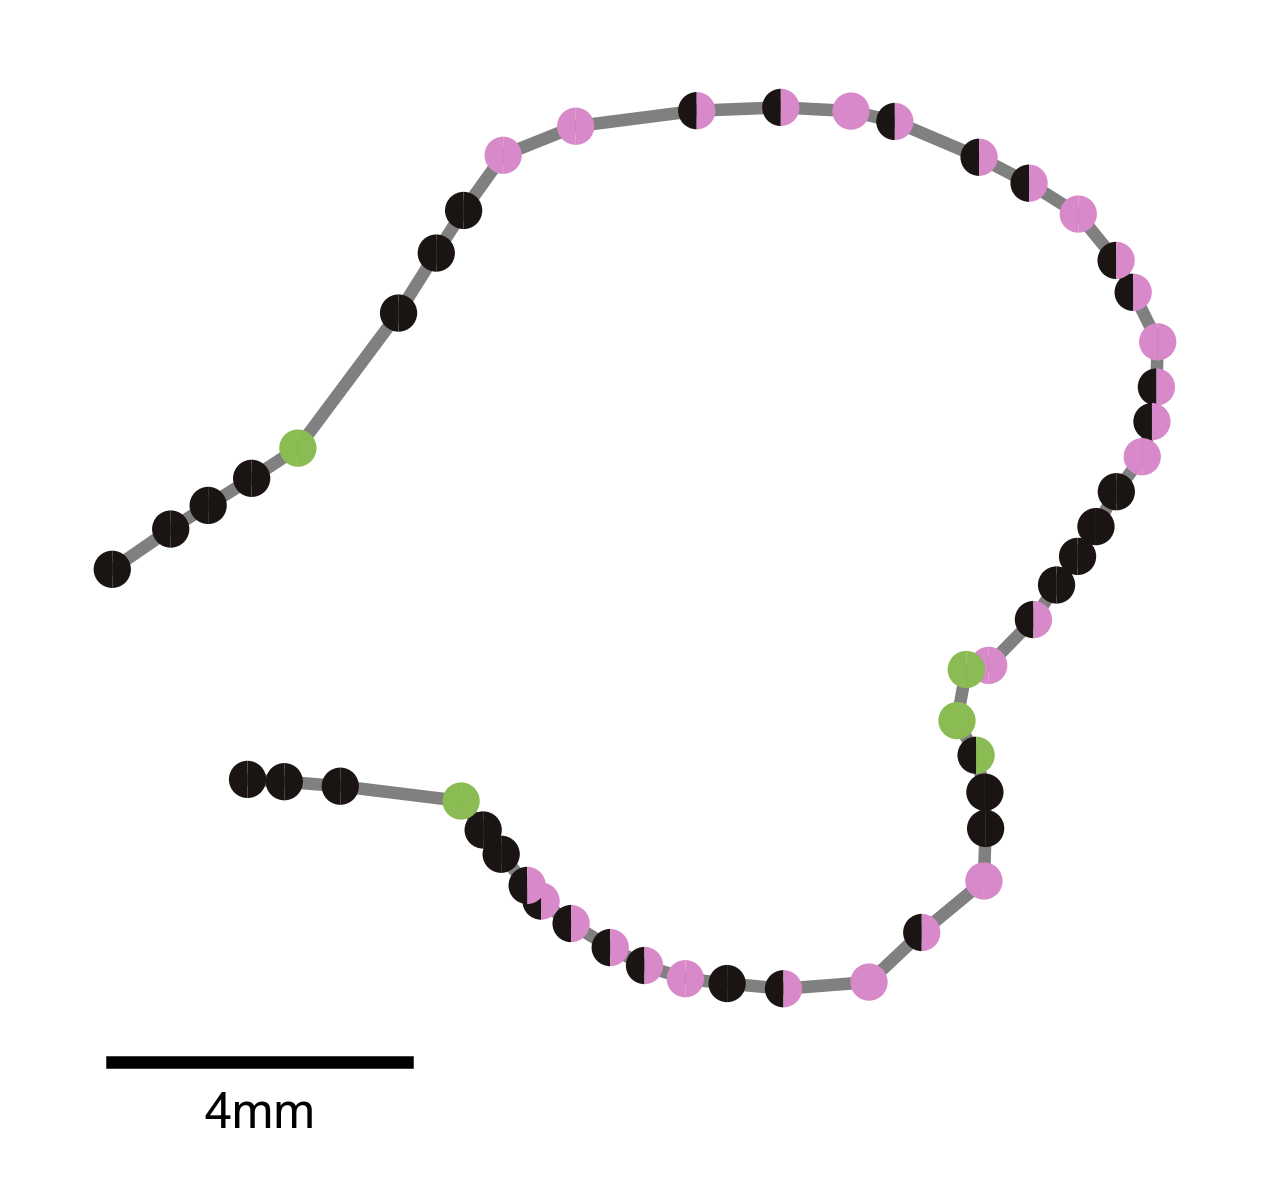

In [11]:
fig, ax = plt.subplots(figsize=(2,2))
ax.axis("off")
ax.set_aspect("equal")
X = xpos[start:stop]
Y = ypos[start:stop]
Cmc = FLR_colors[bouts[start:stop]]
Chmm = FLR_colors[bouts_hmm[start:stop]]

ax.plot(X,Y, zorder=0, color="grey")
ax.scatter(
    X, Y, c=Cmc, 
    zorder=1, marker=MarkerStyle("o", fillstyle="left"), 
    s=20, linewidth=0
)
ax.scatter(
    X, Y, c=Chmm, 
    zorder=1, marker=MarkerStyle("o", fillstyle="right"), 
    s=20, linewidth=0
)

ymin = Y.min() - 1
xmin = X.min()
ax.plot([xmin,xmin+4],[ymin,ymin])
ax.text(xmin+2,ymin-0.4,"4mm",ha="center", va="top")

#fig.savefig(f"panels/Fig2/example_labeling_part2.svg")

## Panel : Streaks

In [15]:
from utils.misc import find_streaks, streak_decay_const

In [16]:
lenghts = np.arange(1,20)

In [17]:
# at all temperatures
Decays = np.empty((len(TEMPS), 2, 2)) # ( temps x model x (F,T) )
for t,temp in enumerate(TEMPS):
    X = load_sequences(bDATAPATH, temp)
    bouts_mc = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    bouts_hmm = load_viterbi(bMODELPATH, "g3", temp)
    streak_lengths_hmm = find_streaks(bouts_hmm, [0,1,2], lenghts)
    streak_lengths_mc = find_streaks(bouts_mc, [0,1,2], lenghts)
    Decays[t,0,0], Decays[t,0,1], _, _ = streak_decay_const(streak_lengths_mc, lenghts)
    Decays[t,1,0], Decays[t,1,1], _, _ = streak_decay_const(streak_lengths_hmm, lenghts)

In [18]:
# at example temperature
temp = 22
X = load_sequences(bDATAPATH, temp)
bouts_mc = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
bouts_hmm = load_viterbi(bMODELPATH, "g3", temp)
streak_lengths_hmm = find_streaks(bouts_hmm, [0,1,2], lenghts)
streak_lengths_mc = find_streaks(bouts_mc, [0,1,2], lenghts)

Text(0, 0.5, '$P(L)$')

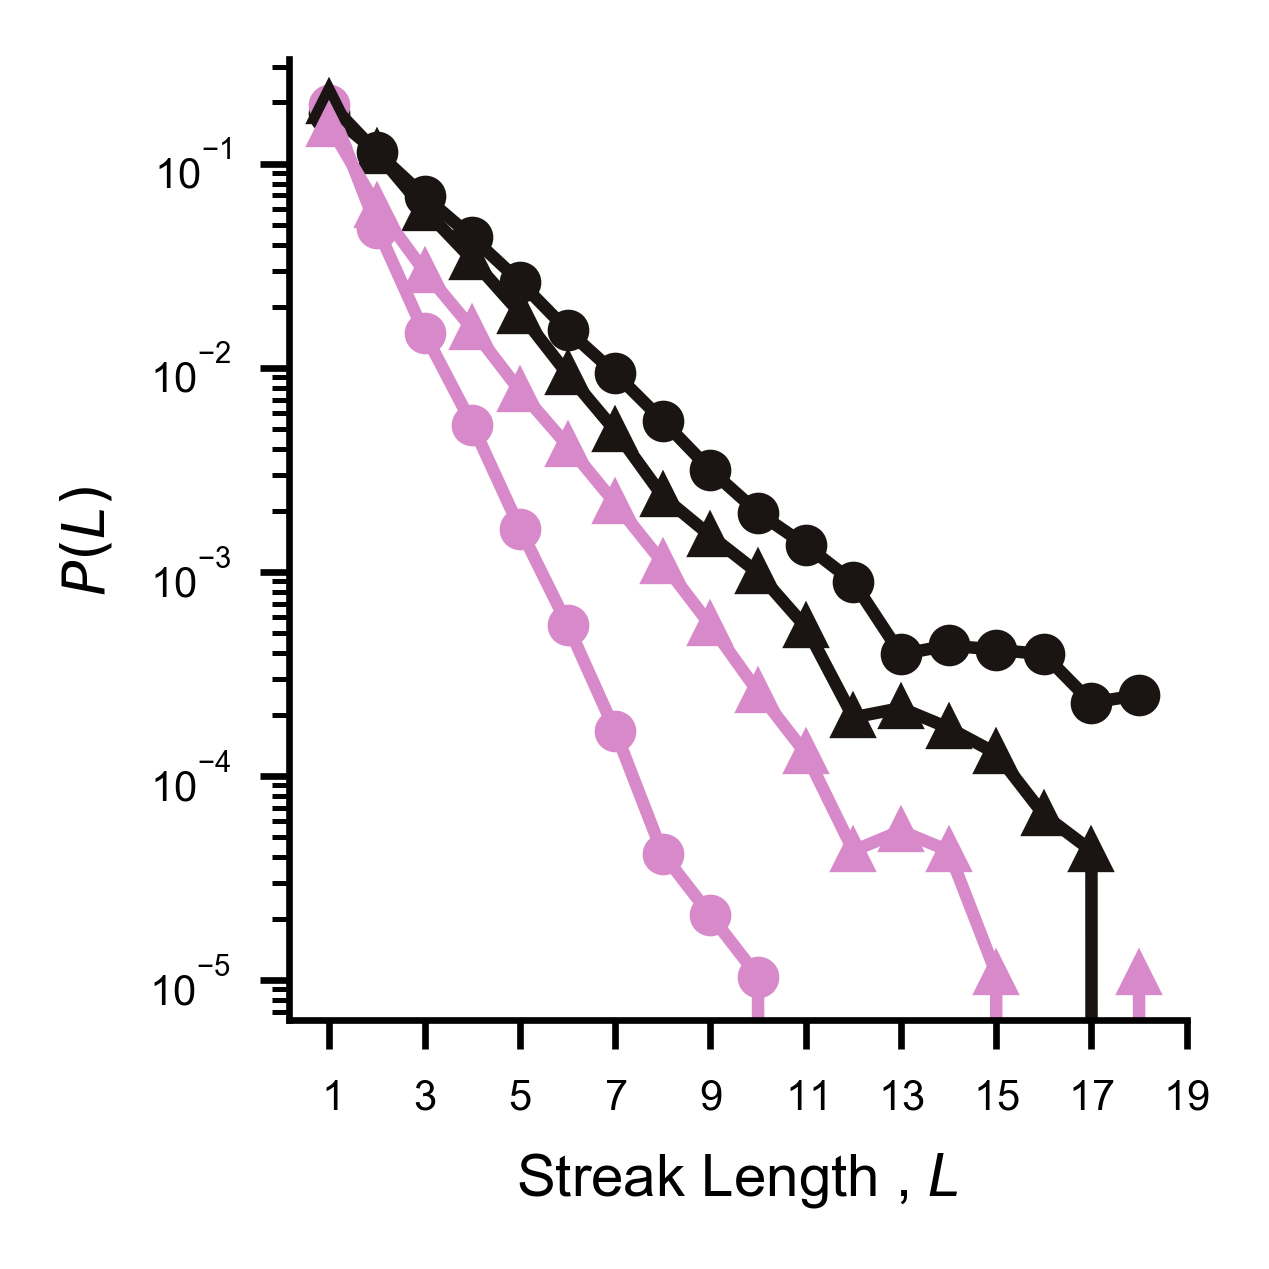

In [19]:
fig, ax = plt.subplots()

ax.plot(lenghts[:-1], streak_lengths_mc[0], "-o", color=FLR_colors[0], markersize=4)
ax.plot(lenghts[:-1], streak_lengths_mc[1:].mean(axis=0), "-o", color=FLR_colors[2], markersize=4)

ax.plot(lenghts[:-1], streak_lengths_hmm[0], "-^", color=FLR_colors[0], markersize=4)
ax.plot(lenghts[:-1], streak_lengths_hmm[1:].mean(axis=0), "-^", color=FLR_colors[2], markersize=4)

ax.set_yscale("log")
#ax.set_xlim(0,30)
ax.set_xticks(lenghts[::2])
ax.set_xlabel(r"Streak Length , $L$")
ax.set_ylabel(r"$P(L)$")

#sx, sy = 0.4, 0.3
#axins = ax.inset_axes([1-sx,1-sy,sx,sy])
#axins.plot(TEMPS, Decays[:,0,0], "-o", color=FLR_colors[0], zorder=0, markersize=2, linewidth=0.5)
#axins.plot(TEMPS, Decays[:,0,1], "-o", color=FLR_colors[2], zorder=2, markersize=2, linewidth=0.5)
#axins.plot(TEMPS, Decays[:,1,0], "-^", color=FLR_colors[0], zorder=1, markersize=2, linewidth=0.5)
#axins.plot(TEMPS, Decays[:,1,1], "-^", color=FLR_colors[2], zorder=3, markersize=2, linewidth=0.5)
#axins.set_xticks(TEMPS);
#axins.set_xlabel("Temperature (°C)")
#axins.set_ylabel(r"$L_0$")

#fig.savefig("panels/Fig2/streaks.svg")

Text(0, 0.5, '$L_0$')

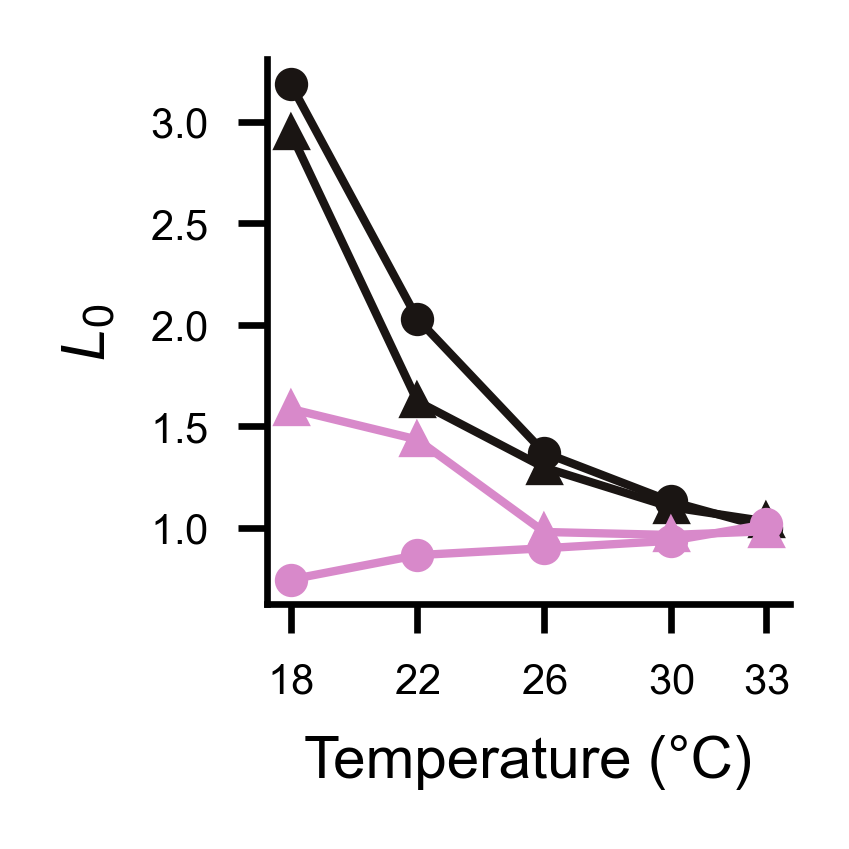

In [20]:
fig, ax = plt.subplots(figsize=(1.3,1.3))
ax.plot(TEMPS, Decays[:,0,0], "-o", color=FLR_colors[0], zorder=0, markersize=3, linewidth=1)
ax.plot(TEMPS, Decays[:,0,1], "-o", color=FLR_colors[2], zorder=2, markersize=3, linewidth=1)
ax.plot(TEMPS, Decays[:,1,0], "-^", color=FLR_colors[0], zorder=1, markersize=3, linewidth=1)
ax.plot(TEMPS, Decays[:,1,1], "-^", color=FLR_colors[2], zorder=3, markersize=3, linewidth=1)
ax.set_xticks(TEMPS);
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel(r"$L_0$")
#fig.savefig("panels/Fig2/streaks_length.svg")

In [21]:
t = 1
temp = TEMPS[t]
Decays[t]
print(f"MC : turn={Decays[t,0,1]:0.2f}, forwards={Decays[t,0,0]:0.2f}")
print(f"HMM : turn={Decays[t,1,1]:0.2f}, forwards={Decays[t,1,0]:0.2f}")

MC : turn=0.87, forwards=2.03
HMM : turn=1.43, forwards=1.62


## Panel P(b|b)/P(b)

In [47]:
def transition_FLR_to_FT(T3):
    P3 = MC.steady_state(T3)
    P2 = np.array([P3[0], 1-P3[0]])
    T2 = np.array([
        [ T3[0,0]                        ,  T3[0,1] + T3[0,2] ],
        [ (T3[0,1] + T3[0,2])*P2[0]/P2[1],  T3[1:,1:].sum(axis=1).mean() ]
    ])
    return P2, T2

In [48]:
# getting P(b|b)/P(b) for Markov Chain from threhsolded data
n_rep = 100
frac = 0.5

P_bbb_mc = np.empty( (len(TEMPS), 2, 3) ) # ( temp x bout_type x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    X = load_sequences(bDATAPATH, temp)
    bouts = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    bouts = [np.where(bout==2,1,bout) for bout in bouts]
    inds = np.arange(len(bouts))
    fracN = int(frac*len(bouts))
    Pb, T = [], []
    for r in range(n_rep):
        np.random.shuffle(inds)
        Pb.append(MC.bout_proba([bouts[i] for i in inds[:fracN]], n_state=2))
        T.append(MC.bout_transitions([bouts[i] for i in inds[:fracN]], n_state=2))
    Pb = np.c_[Pb]
    T = np.c_[T]
    Pbbb = T[:,[0,1],[0,1]] / Pb
    P_bbb_mc[t,:,1] = Pbbb.mean(axis=0)
    P_bbb_mc[t,:,2] = Pbbb.ptp(axis=0)/2
    P_bbb_mc[t,:,0] = MC.bout_transitions(bouts, n_state=2)[[0,1], [0,1]] / MC.bout_proba(bouts, n_state=2)

In [49]:
# getting P(b) and P(b|b) for HMM3
n_rep = 100
frac = 0.5

P_bbb_hmm = np.empty( (len(TEMPS), 2, 3) ) # ( temp x bout_type x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    Ts = load_transmat_multi(bMODELPATH, "g3", temp)
    Pb, T = [], []
    for TT in Ts:
        pp,tt = transition_FLR_to_FT(TT)
        Pb.append(pp)
        T.append(tt)
    Pb = np.c_[Pb]
    T = np.c_[T]
    Pbbb = T[:,[0,1],[0,1]] / Pb
    P_bbb_hmm[t,:,1] = Pbbb.mean(axis=0)
    P_bbb_hmm[t,:,2] = Pbbb.ptp(axis=0)/2

    T = load_transmat(bMODELPATH, "g3", temp)
    Pb = MC.steady_state(T)
    P2, T2 = transition_FLR_to_FT(T)
    P_bbb_hmm[t,:,0] = T2[[0,1], [0,1]] / P2
    

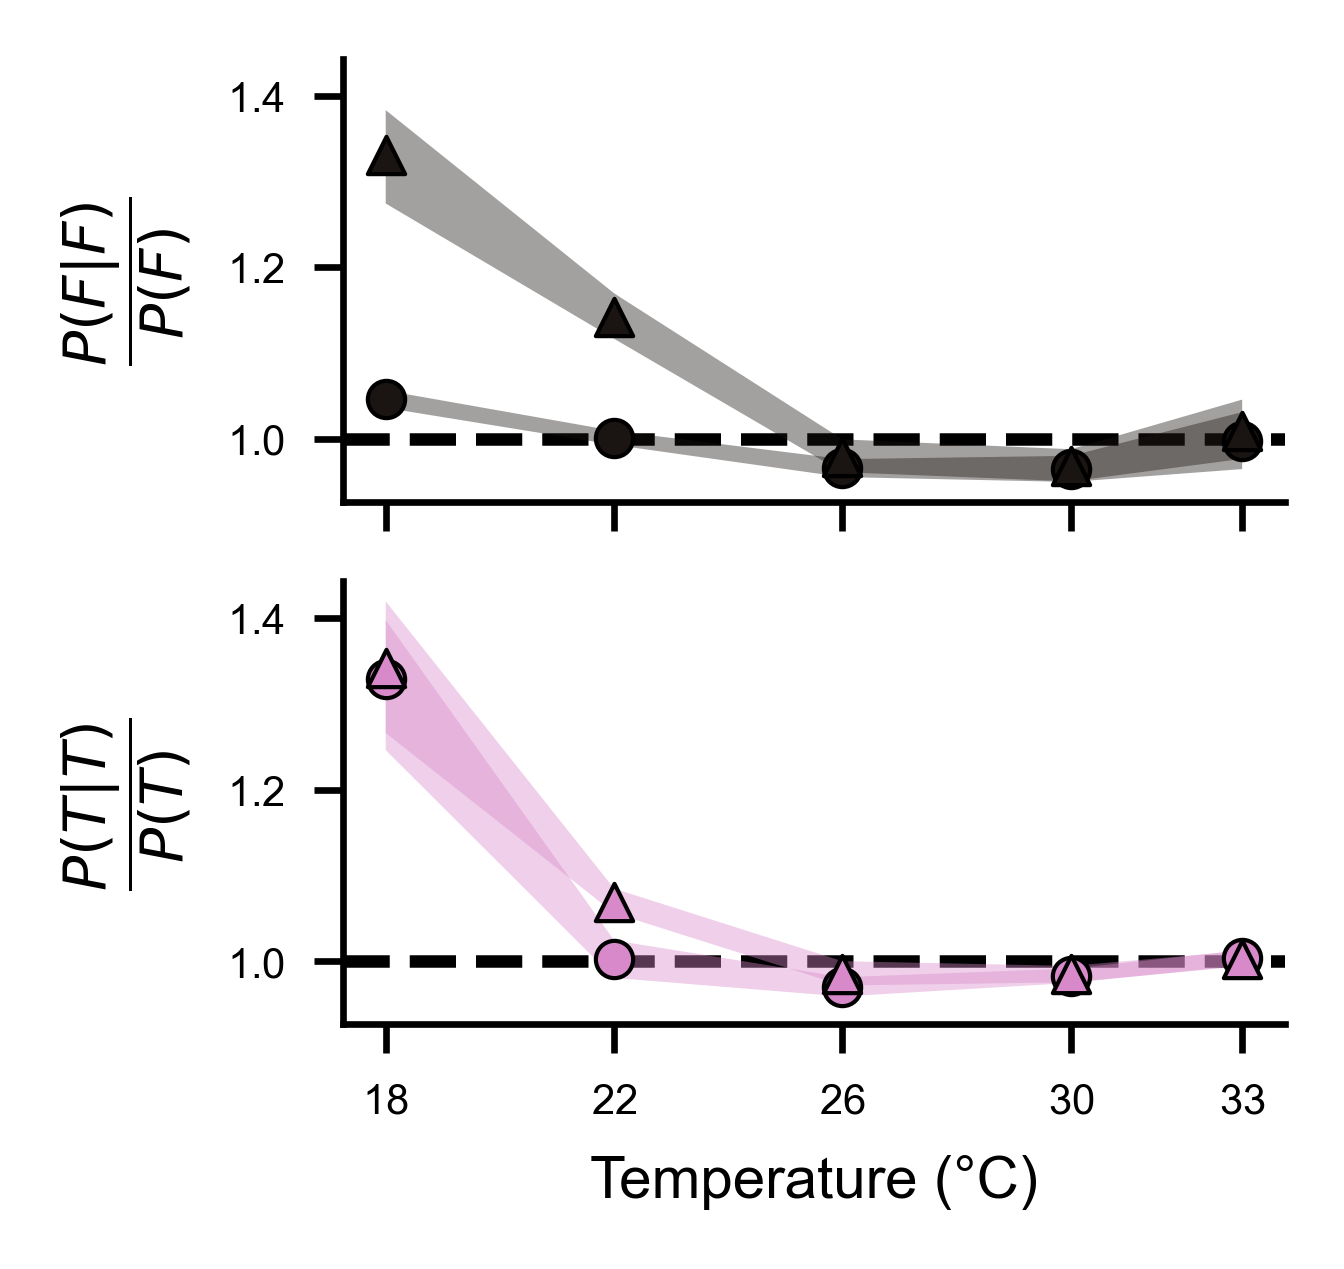

In [50]:
fig, axs = plt.subplots(figsize=(2.125,2), nrows=2, sharex=True, sharey=True)
ax1, ax2 = axs

# MC
ax1.scatter(
    TEMPS, P_bbb_mc[:,0,0], 
    marker="o", facecolor=FLR_colors[0], 
    edgecolor="k", s=20, linewidth=0.5, zorder=2
)
ax1.fill_between(
    TEMPS, 
    P_bbb_mc[:,0,1]+P_bbb_mc[:,0,2], 
    P_bbb_mc[:,0,1]-P_bbb_mc[:,0,2], 
    color=FLR_colors[0], alpha=0.4, zorder=1,
    edgecolor=None, linewidth=0.5,
)

ax2.scatter(
    TEMPS, P_bbb_mc[:,1,0], 
    marker="o", facecolor=FLR_colors[2], 
    edgecolor="k", s=20, linewidth=0.5, zorder=2
)
ax2.fill_between(
    TEMPS, 
    P_bbb_mc[:,1,1]+P_bbb_mc[:,1,2], 
    P_bbb_mc[:,1,1]-P_bbb_mc[:,1,2], 
    color=FLR_colors[2], alpha=0.4, zorder=1,
    edgecolor=None, linewidth=0.5,
)

# HMM
ax1.scatter(
    TEMPS, P_bbb_hmm[:,0,0], 
    marker="^", facecolor=FLR_colors[0], 
    edgecolor="k", s=20, linewidth=0.5, zorder=2
)
ax1.fill_between(
    TEMPS, 
    P_bbb_hmm[:,0,1]+P_bbb_hmm[:,0,2], 
    P_bbb_hmm[:,0,1]-P_bbb_hmm[:,0,2], 
    color=FLR_colors[0], alpha=0.4, zorder=1,
    edgecolor=None, linewidth=0.5,
)

ax2.scatter(
    TEMPS, P_bbb_hmm[:,1,0], 
    marker="^", facecolor=FLR_colors[2], 
    edgecolor="k", s=20, linewidth=0.5, zorder=2
)
ax2.fill_between(
    TEMPS, 
    P_bbb_hmm[:,1,1]+P_bbb_hmm[:,1,2], 
    P_bbb_hmm[:,1,1]-P_bbb_hmm[:,1,2], 
    color=FLR_colors[2], alpha=0.4, zorder=1,
    edgecolor=None, linewidth=0.5,
)

ax1.axhline(1, linestyle="--", color="k", zorder=0)
ax2.axhline(1, linestyle="--", color="k", zorder=0)
ax2.set_xticks(TEMPS)
ax2.set_xlabel("Temperature (°C)")
ax1.set_ylabel(r"$\dfrac{P(F|F)}{P(F)}$")
ax2.set_ylabel(r"$\dfrac{P(T|T)}{P(T)}$");

fig.savefig("panels/Fig2/Pbbb.svg")

## Stubbornness All temps - q=0

In [56]:
q = 0
Fs_mc, Fs_hmm3 = [], []
for temp in TEMPS:
    seqs = MC.threshold_classifier(load_sequences(bDATAPATH, temp), -DTHETA_THRESH, +DTHETA_THRESH)
    centered = MC.center_bouts(seqs)
    Fs_mc.append(MC.stubbornness_factor(centered, q=q))
    
    seqs = load_viterbi(bMODELPATH, "g3", temp)
    centered = MC.center_bouts(seqs)
    Fs_hmm3.append(MC.stubbornness_factor(centered, q=q))

Fs_mc = np.array(Fs_mc)
Fs_hmm3 = np.array(Fs_hmm3)

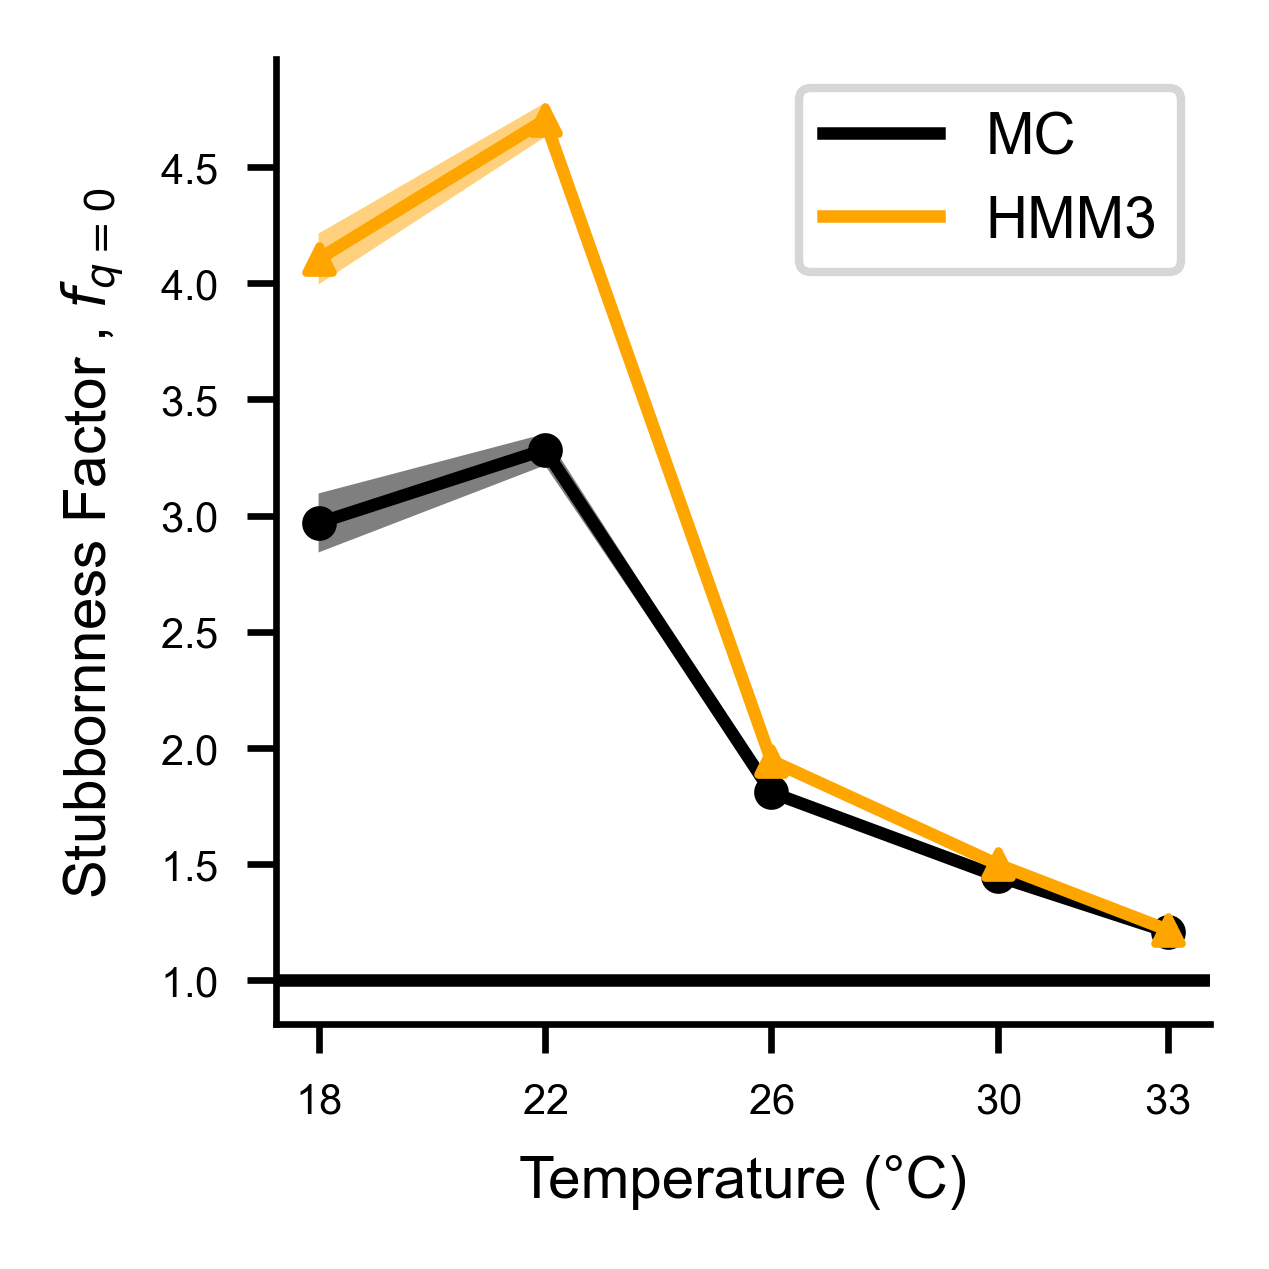

In [57]:
fig, ax = plt.subplots()

ax.scatter(TEMPS, Fs_mc[:,0], marker="o", s=10, zorder=2, color=COLORS["mc"])
ax.plot(TEMPS, Fs_mc[:,0], zorder=1, color=COLORS["mc"], label="MC")
ax.fill_between(TEMPS, Fs_mc[:,0]-Fs_mc[:,1], Fs_mc[:,0]+Fs_mc[:,1], zorder=0, color=COLORS["mc"], alpha=0.5, edgecolor=None)

ax.scatter(TEMPS, Fs_hmm3[:,0], marker="^", s=10, zorder=5, color=COLORS["hmm3"])
ax.plot(TEMPS, Fs_hmm3[:,0], zorder=4, color=COLORS["hmm3"], label="HMM3")
ax.fill_between(TEMPS, Fs_hmm3[:,0]-Fs_hmm3[:,1], Fs_hmm3[:,0]+Fs_hmm3[:,1], zorder=3, color=COLORS["hmm3"], alpha=0.5, edgecolor=None)

ax.axhline(1)
ax.set_xticks(TEMPS)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel(r"Stubbornness Factor , $f_{q=0}$")
ax.legend()
fig.savefig("panels/Fig2/Stubb_MC_HMM3_q0.svg")

## Stubbornness All temps - q=1

In [58]:
q = 1
Fs_mc, Fs_hmm3 = [], []
for temp in TEMPS:
    seqs = MC.threshold_classifier(load_sequences(bDATAPATH, temp), -DTHETA_THRESH, +DTHETA_THRESH)
    centered = MC.center_bouts(seqs)
    Fs_mc.append(MC.stubbornness_factor(centered, q=q))
    
    seqs = load_viterbi(bMODELPATH, "g3", temp)
    centered = MC.center_bouts(seqs)
    Fs_hmm3.append(MC.stubbornness_factor(centered, q=q))

Fs_mc = np.array(Fs_mc)
Fs_hmm3 = np.array(Fs_hmm3)

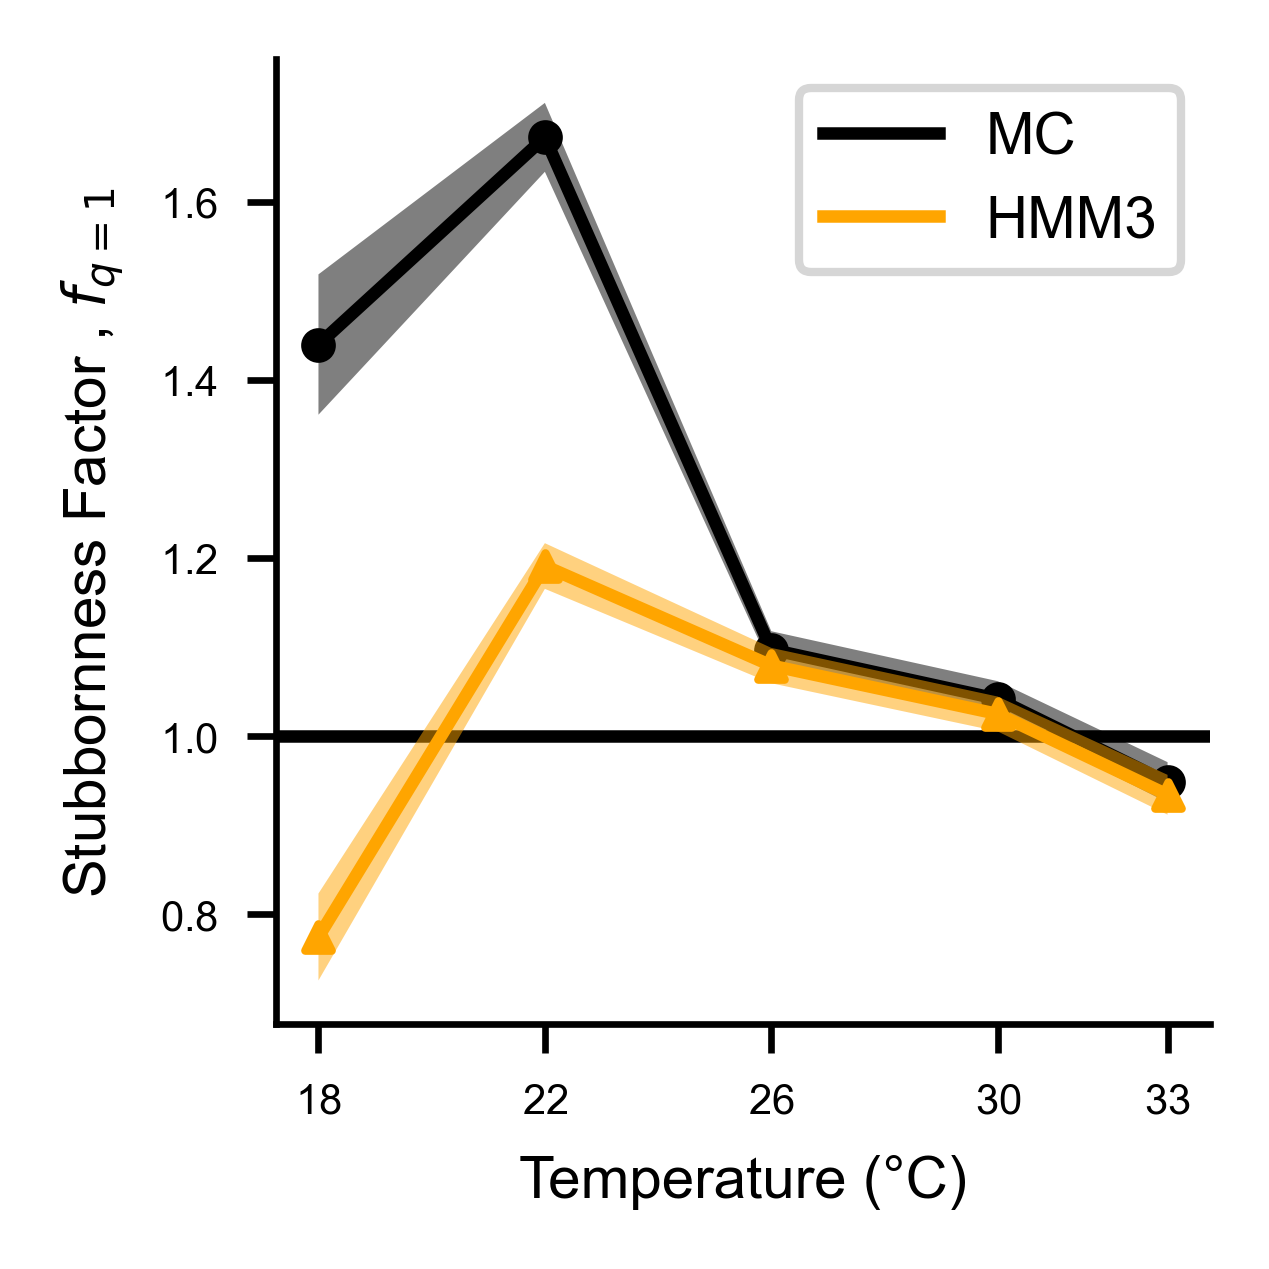

In [59]:
fig, ax = plt.subplots()

ax.scatter(TEMPS, Fs_mc[:,0], marker="o", s=10, zorder=2, color=COLORS["mc"])
ax.plot(TEMPS, Fs_mc[:,0], zorder=1, color=COLORS["mc"], label="MC")
ax.fill_between(TEMPS, Fs_mc[:,0]-Fs_mc[:,1], Fs_mc[:,0]+Fs_mc[:,1], zorder=0, color=COLORS["mc"], alpha=0.5, edgecolor=None)

ax.scatter(TEMPS, Fs_hmm3[:,0], marker="^", s=10, zorder=5, color=COLORS["hmm3"])
ax.plot(TEMPS, Fs_hmm3[:,0], zorder=4, color=COLORS["hmm3"], label="HMM3")
ax.fill_between(TEMPS, Fs_hmm3[:,0]-Fs_hmm3[:,1], Fs_hmm3[:,0]+Fs_hmm3[:,1], zorder=3, color=COLORS["hmm3"], alpha=0.5, edgecolor=None)

#ax.plot(TEMPS, Fs_gen[:,0], zorder=1, color=COLORS["gen"], label="GEN")
#ax.fill_between(TEMPS, Fs_gen[:,0]-Fs_gen[:,1], Fs_gen[:,0]+Fs_gen[:,1], zorder=0, color=COLORS["gen"], alpha=0.5, edgecolor=None)

ax.axhline(1)
ax.set_xticks(TEMPS)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel(r"Stubbornness Factor , $f_{q=1}$")
ax.legend()
fig.savefig("panels/Fig2/Stubb_MC_HMM3_q1.svg")

# Supplementaries

## confusion matrices

Text(0, 0.5, 'HMM labeling')

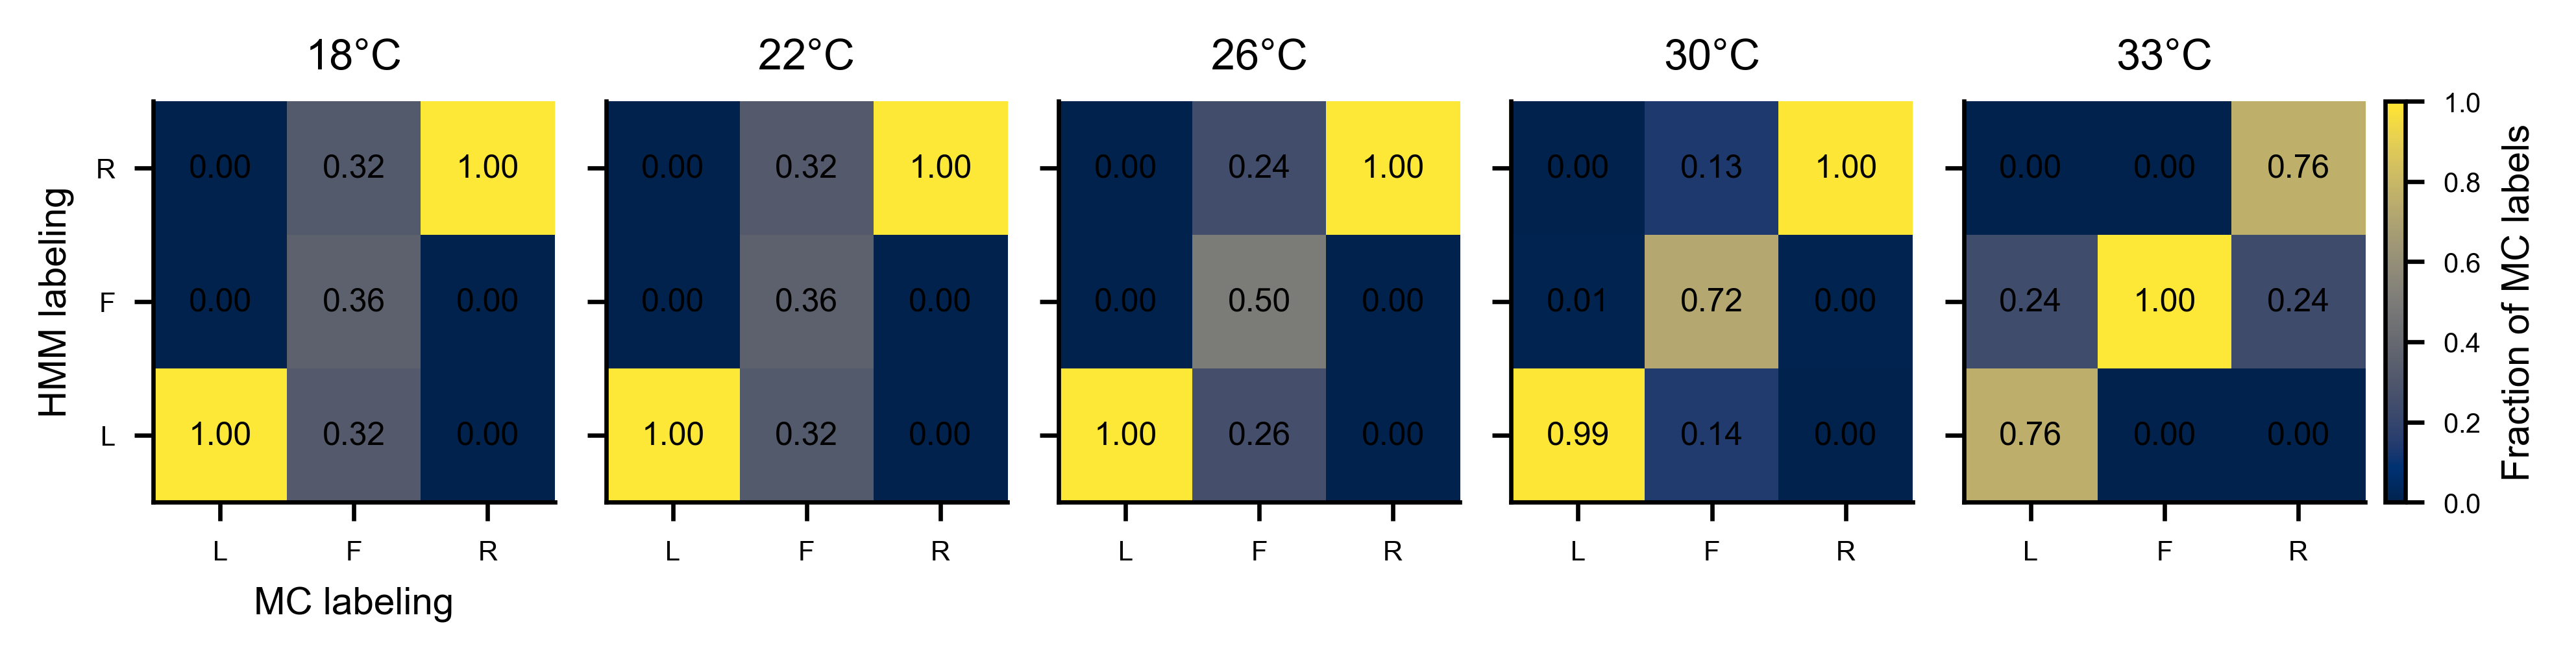

In [22]:
fig, axs = plt.subplots(ncols = len(TEMPS), figsize=(len(TEMPS)*1.3, 1.3 + 0.5), sharex=True, sharey=True)

for ax, temp in zip(axs,TEMPS):
    C = confusion(
        MC.threshold_classifier(load_sequences(bDATAPATH, temp), -DTHETA_THRESH, +DTHETA_THRESH), 
        load_viterbi(bMODELPATH, "g3", temp),
        3,
        3
    )
    h = plot_confusion(ax, 
        C[[1,0,2],:][:,[1,0,2]],
        ["L","F","R"],
        ["L","F","R"],
    )
    ax.set_title(f"{temp}°C")

fig.colorbar(h, ax=ax, label="Fraction of MC labels", shrink=0.60)
axs[0].set_xlabel("MC labeling")
axs[0].set_ylabel("HMM labeling")

#fig.savefig("panels/Fig2/supps/confusion.svg")

## QQ plots - Mixture Model

In [24]:
extract_models('../Models/mixtures.tar.gz')
qqfile = h5py.File("../Models/mixtures.h5")

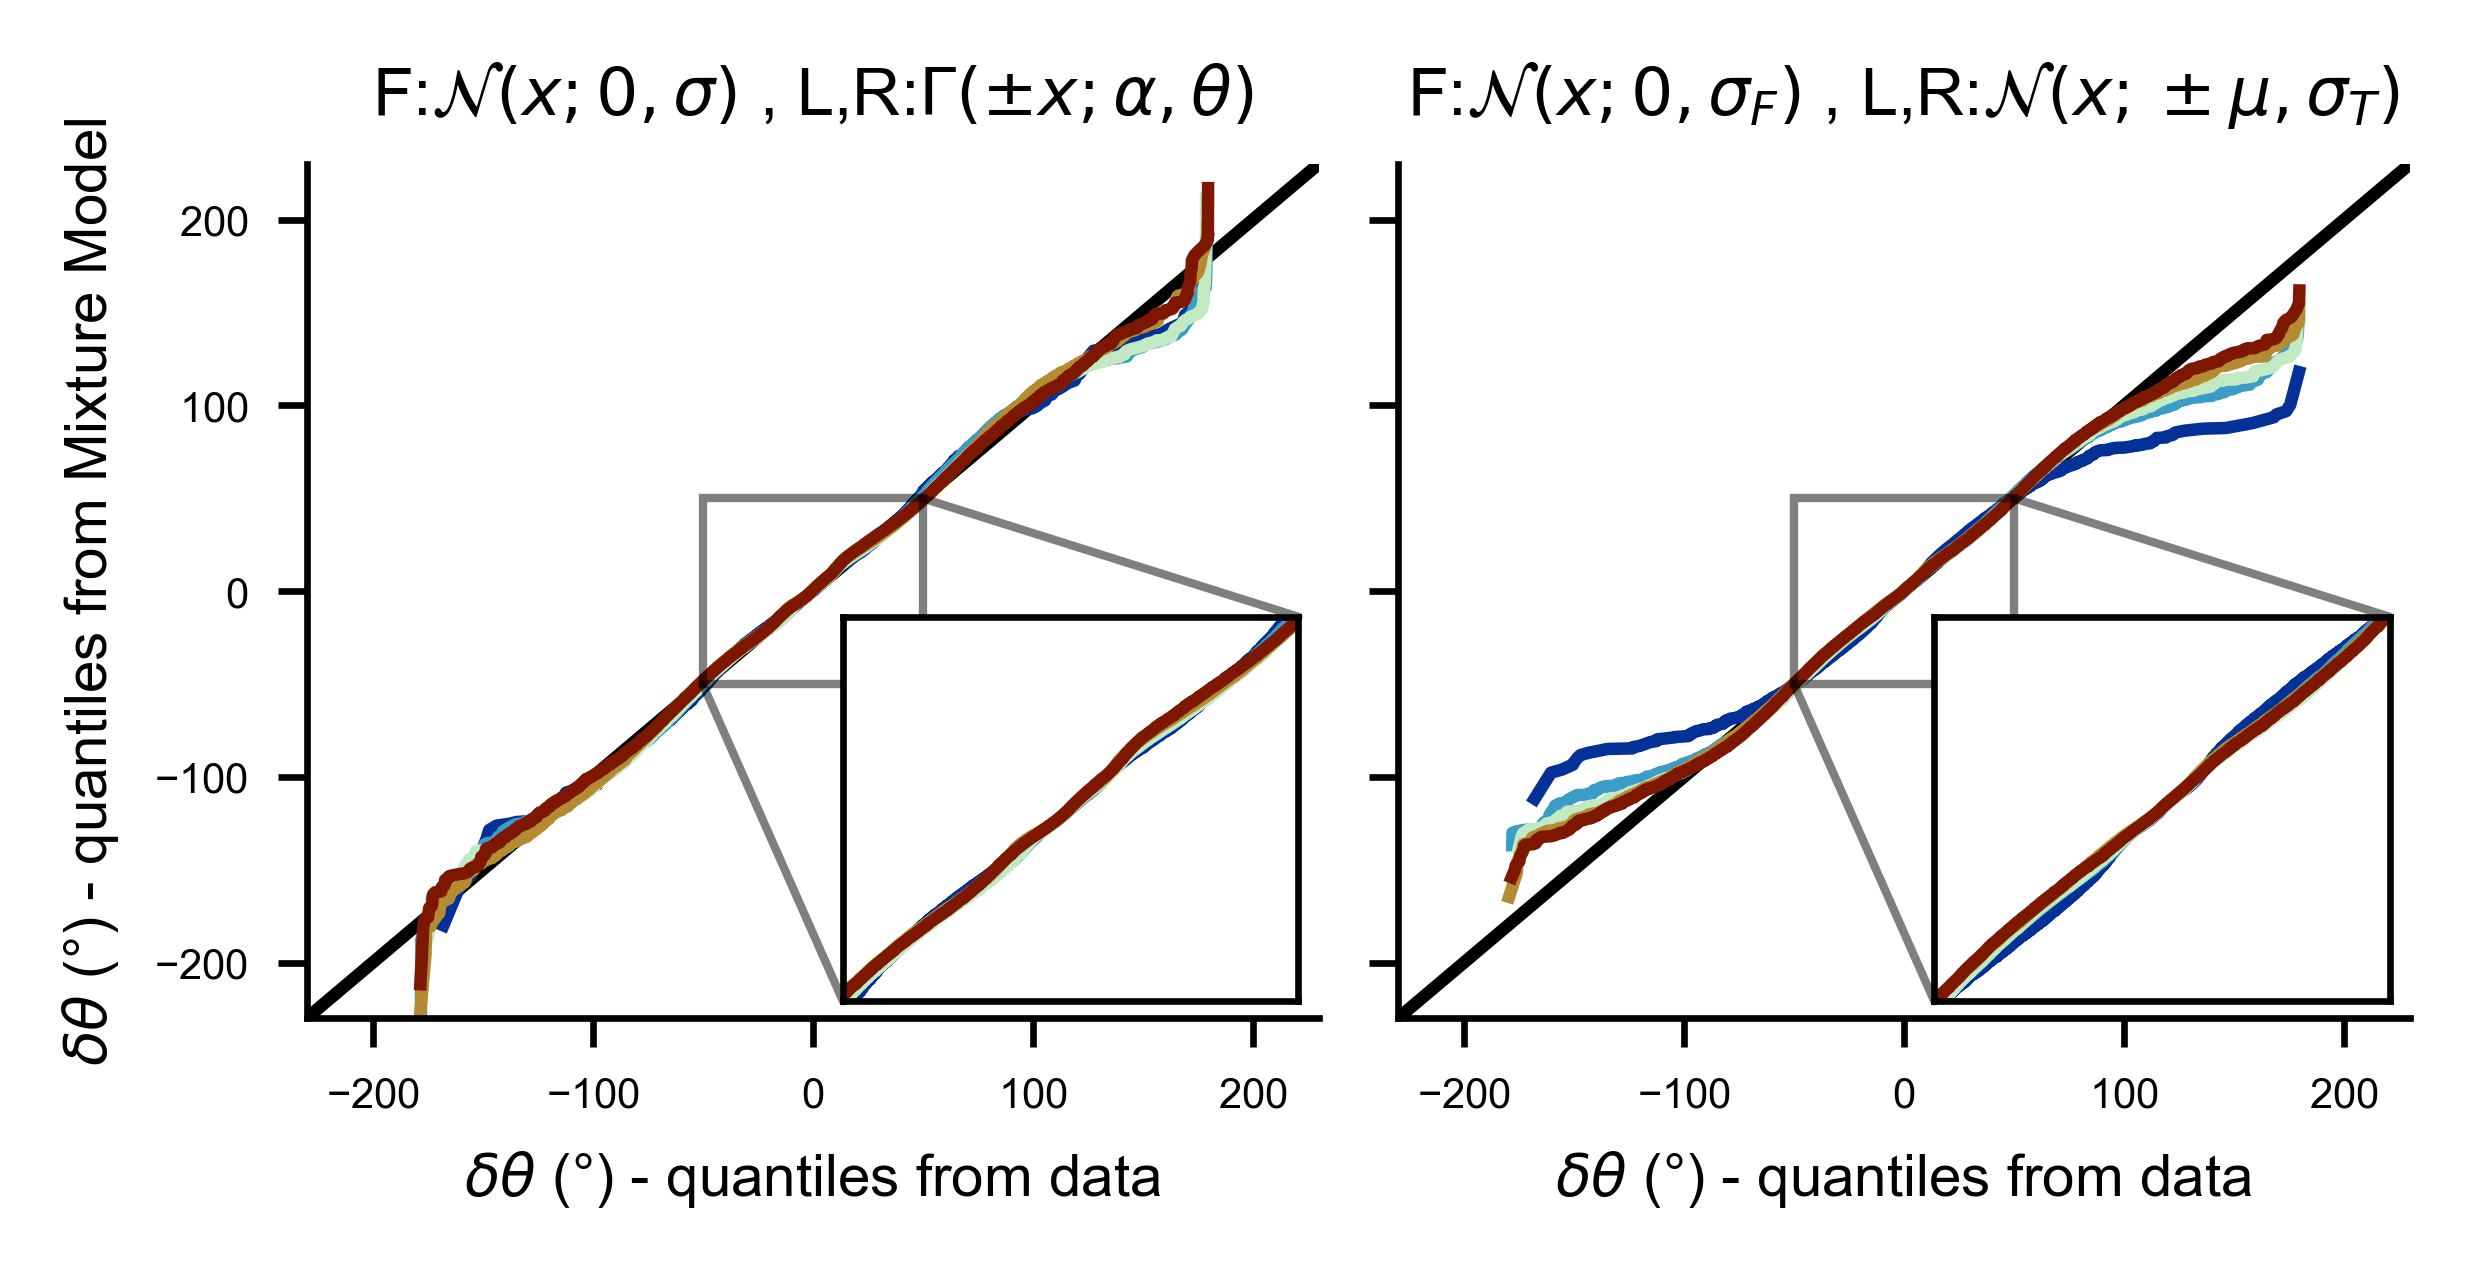

In [25]:
mmin, mmax = -230, +230
immin, immax = -50, +50
insize, inpad = 0.45, 0.02

fig, axs = plt.subplots(ncols=2, figsize=(2*2,2), sharex=True, sharey=True)

axs[0].set_title(r"F:$\mathcal{N}(x;0,\sigma)$ , L,R:$\Gamma(\pm x;\alpha,\theta)$")
axs[1].set_title(r"F:$\mathcal{N}(x;0,\sigma_F)$ , L,R:$\mathcal{N}(x;\pm\mu,\sigma_T)$")

axins = []
for ax in axs:
    ax.set_xlim(mmin, mmax)
    ax.set_ylim(mmin, mmax)
    ax.set_xlabel(r"$\delta \theta$ (°) - quantiles from data")
    ax.plot([mmin, mmax], [mmin, mmax], color="k" ,linestyle="-", zorder=0)
    axin = ax.inset_axes(
        [1-inpad-insize,inpad, insize, insize],
        xlim=(immin, immax),
        ylim=(immin, immax),
        xticklabels=[], yticklabels=[],
    )
    axin.spines[['right', 'top']].set_visible(True)
    axin.tick_params(left=False, bottom=False)
    ax.indicate_inset_zoom(axin, edgecolor="black")
    axins.append(axin)
    
axs[0].set_ylabel(r"$\delta \theta$ (°) - quantiles from Mixture Model")
    
for temp in TEMPS:
    for ax, axin, dset in zip(axs, axins, ["Gamma-Normal-Gamma","Normal-Normal-Normal"]):#, "TruncNormal-Normal-TruncNormal"]):
        QQx = qqfile[f"{temp}/{dset}/QQx"][:]
        QQy = qqfile[f"{temp}/{dset}/QQy"][:]
        ax.plot(QQx, QQy, color=TEMPS_COLS[temp])
        axin.plot(QQx, QQy, color=TEMPS_COLS[temp])

#fig.savefig("panels/Fig2/supps/qqplots_mixtures.svg")

In [26]:
qqfile.close()

## Reproduction of reorientation distributions

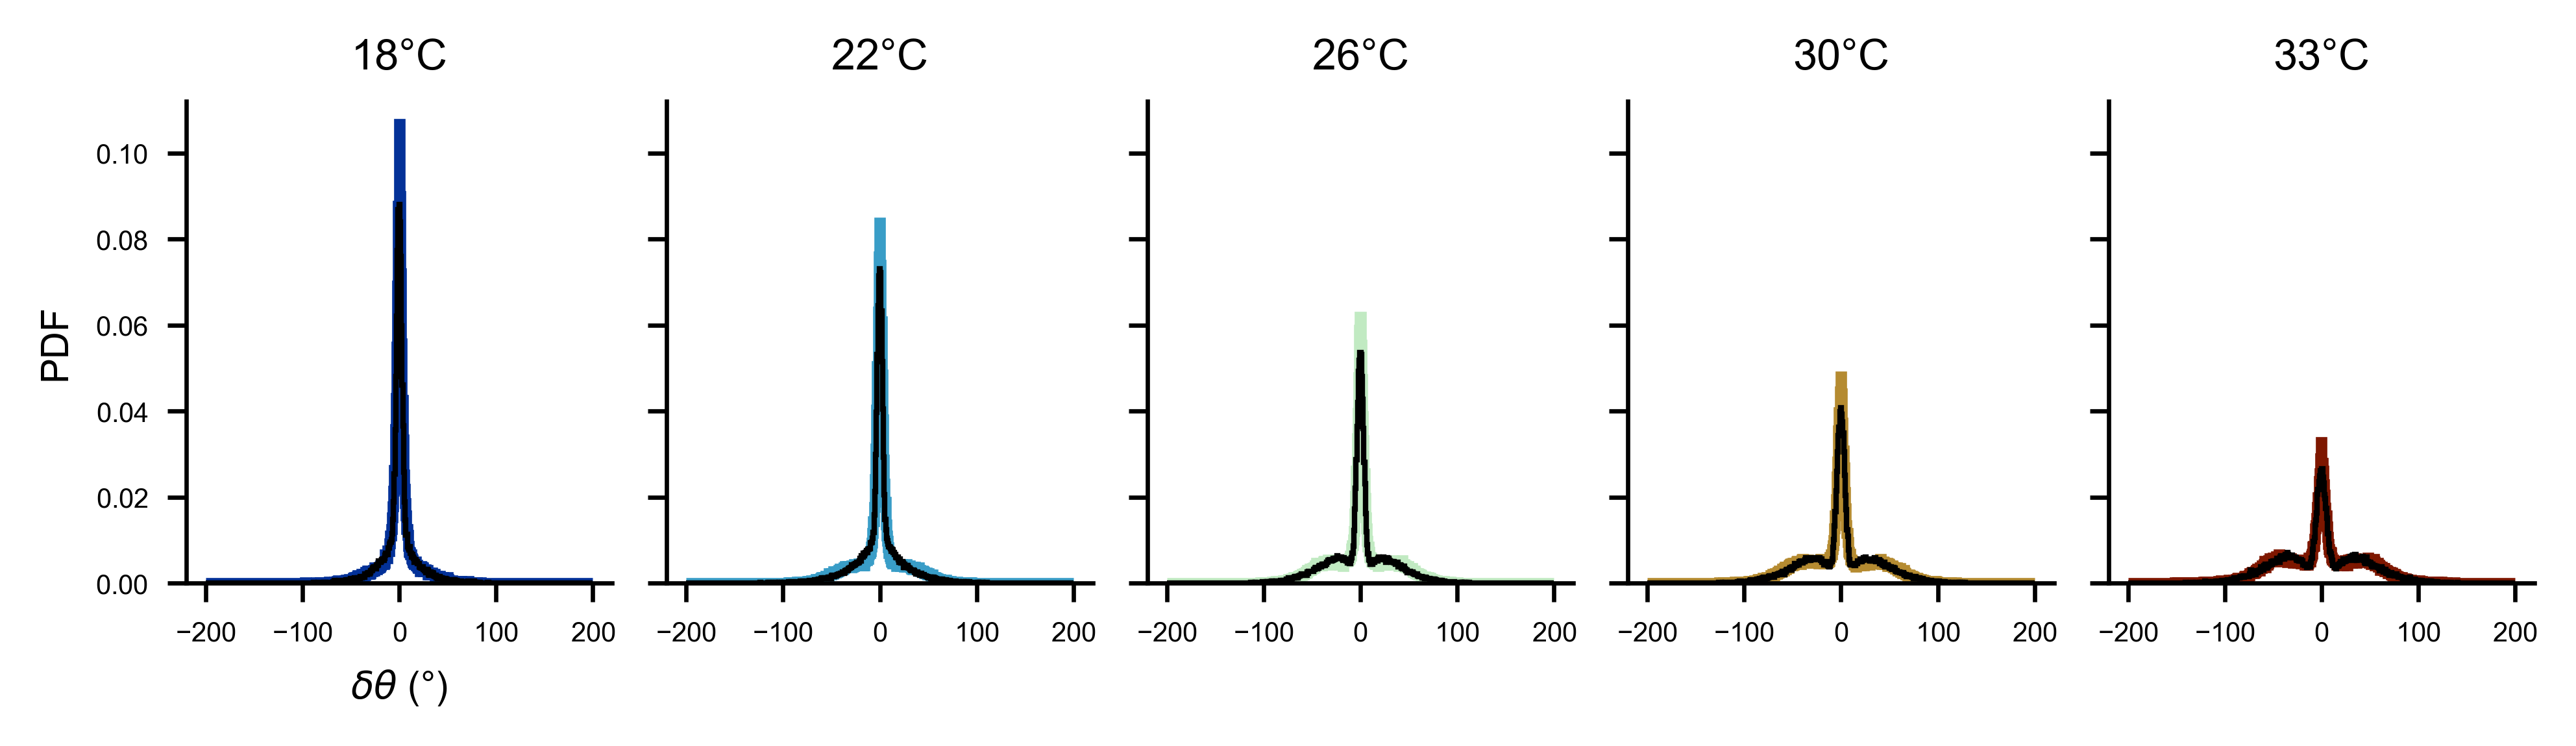

In [27]:
fig, axs = plt.subplots(ncols = len(TEMPS), figsize=(len(TEMPS)*1.3, 1.3 + 0.5), sharex=True, sharey=True)

bins = np.linspace(-200, +200, 500)

axs[0].set_xlabel(r"$\delta \theta$ (°)")
axs[0].set_ylabel("PDF")

for t,temp in enumerate(TEMPS):
    X_data = np.concatenate(load_sequences(bDATAPATH, temp))
    X_gen = np.concatenate(load_genbouts(bMODELPATH, "g3", temp))

    hdata,_ = np.histogram(X_data, bins)
    hdata = hdata/hdata.sum()
    hgen,_ = np.histogram(X_gen, bins)
    hgen = hgen/hgen.sum()
    
    axs[t].hist(X_data, bins=bins, histtype="step", density=True, color=TEMPS_COLS[temp], linewidth=2);
    axs[t].hist(X_gen, bins=bins, histtype="step", density=True, color="k");
    #axs[t].set_title(r"$JSD(data||generated) = "+f"{jsd:0.3f}"+r"$")
    axs[t].set_title(f"{temp}°C")
    #axs[t].set_yscale("log")

#fig.savefig("panels/Fig2/supps/hists_data_vs_g3.svg")

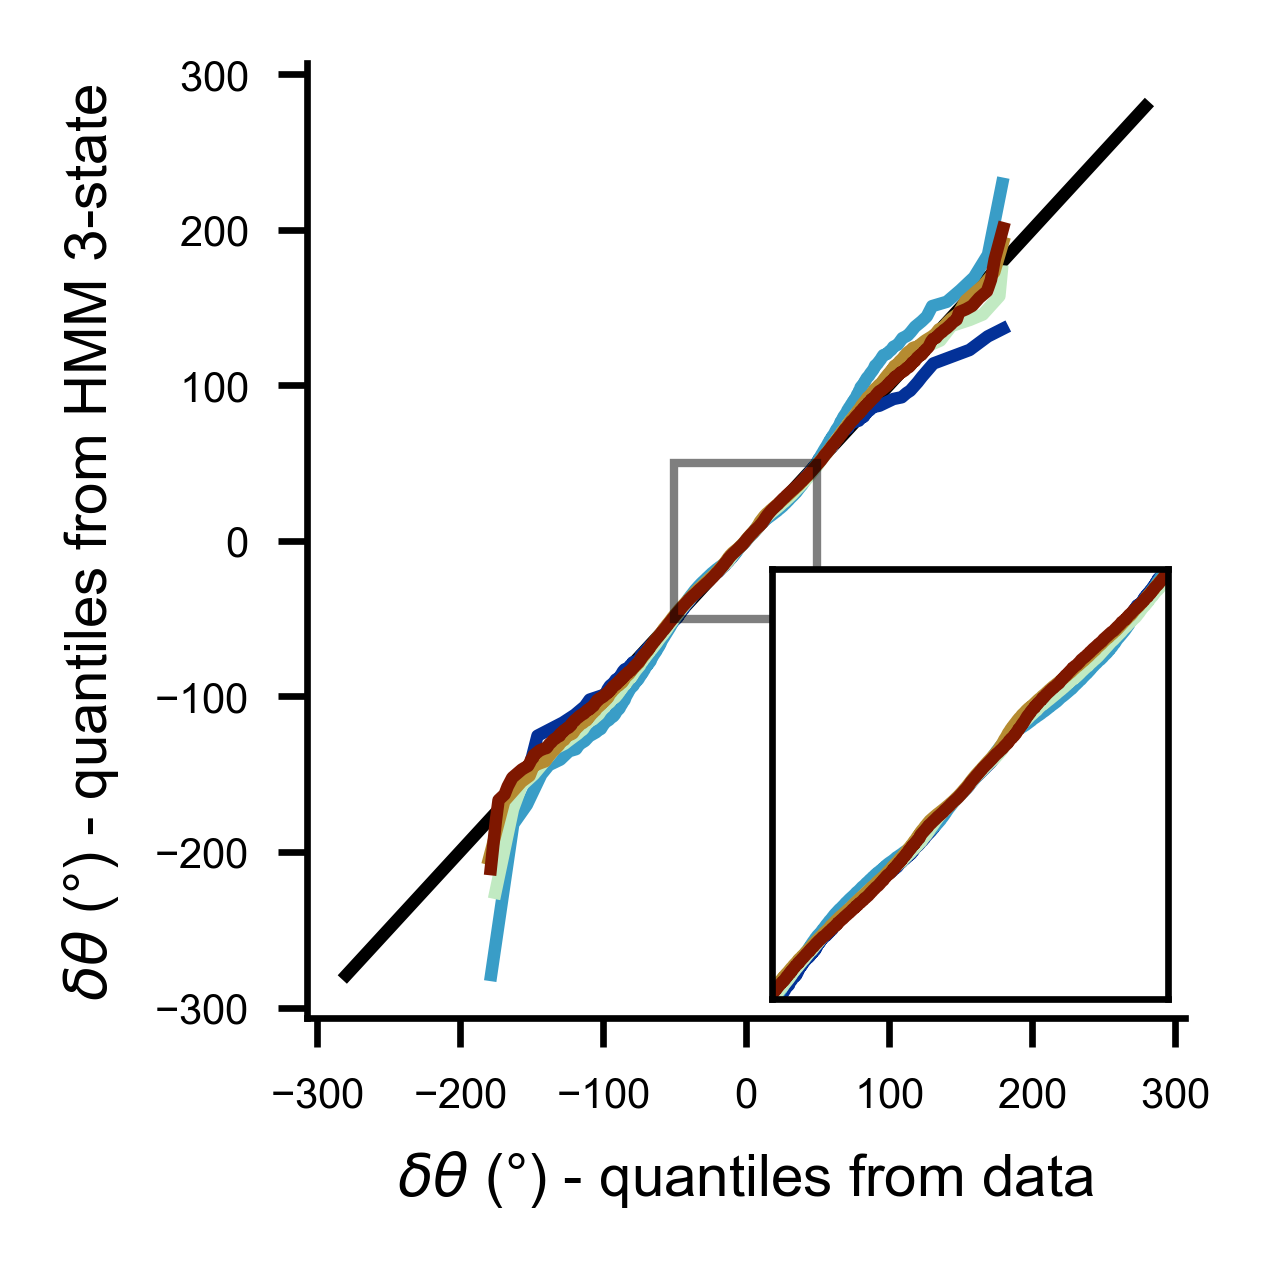

In [29]:
qs = np.linspace(0,1,10000)
immin, immax = -50, +50
insize, inpad = 0.45, 0.02

fig, ax = plt.subplots()

axin = ax.inset_axes(
    [1-inpad-insize,inpad, insize, insize],
    xlim=(immin, immax),
    ylim=(immin, immax),
    xticklabels=[], yticklabels=[],
)
axin.spines[['right', 'top']].set_visible(True)
axin.tick_params(left=False, bottom=False)
ax.indicate_inset_zoom(axin, edgecolor="black")
ax.set_xlabel(r"$\delta \theta$ (°) - quantiles from data")
ax.set_ylabel(r"$\delta \theta$ (°) - quantiles from HMM 3-state")

amax = 0
for t, temp in enumerate(TEMPS):
    X_data = np.concatenate(load_sequences(bDATAPATH, temp))
    X_gen = np.concatenate(load_genbouts(bMODELPATH, "g3", temp))

    Q_data = np.quantile(X_data, qs)
    Q_gen = np.quantile(X_gen, qs)
    amax = max(amax, np.abs(Q_data).max())
    amax = max(amax, np.abs(Q_gen).max())
    ax.plot(Q_data, Q_gen, color=TEMPS_COLS[temp], zorder=1)
    axin.plot(Q_data, Q_gen, color=TEMPS_COLS[temp], zorder=1)

ax.plot([-amax, amax], [-amax, amax], zorder=0)

#fig.savefig("panels/Fig2/supps/qqplots_data_vs_g3.svg")

## Model Likelyhoods

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
def split_train_test(seqs, epochs=100, f=0.75):
    n = len(seqs)
    nt = int(n*f)
    inds = np.arange(n)
    TRAIN = np.empty((epochs, nt), dtype=np.int_)
    TEST = np.empty((epochs, n-nt), dtype=np.int_)
    for e in range(epochs):
        np.random.shuffle(inds)
        TRAIN[e] = inds[:nt]
        TEST[e] = inds[nt:]
    return TRAIN, TEST

def LL_single_sequence(seq, T):
    pb = MC.steady_state(T)
    p1 = pb[seq[0]]
    i = np.arange(len(seq)-1)
    ps = T[seq[i], [seq[i+1]]]
    return np.log(ps).sum() + np.log(p1)
    
def LL_sequences(seqs, T):
    Ps = []
    for seq in seqs:
        Ps.append(LL_single_sequence(seq, T))
    return np.array(Ps)

def LL_temp(temp, thresh=10):
    X = load_sequences(DATAPATH, temp)
    bouts = MC.threshold_classifier(X, -thresh, +thresh)
    train_inds, test_inds = split_train_test(bouts)
    LLHs = np.empty_like(test_inds, dtype=np.float_)
    for e in range(train_inds.shape[0]):
        train = [bouts[i] for i in train_inds[e]]
        test = [bouts[i] for i in test_inds[e]]
        T = MC.bout_transitions(train, n_state=3)
        LLHs[e] = LL_sequences(test, T)
    return LLHs

In [5]:
LLHs = []
Temps = []
MODELS = []
for temp in TEMPS:
    llhs_hmm = load_LLHs(MODELPATH, "g3", temp)
    llhs_mc = LL_temp(temp)
    llhs_mc = llhs_mc.ravel()
    
    LLHs.append(llhs_hmm)
    Temps.append(np.full_like(llhs_hmm, temp, dtype=np.int_))
    MODELS.append(np.full_like(llhs_hmm, "hmm", dtype="<U4"))
    LLHs.append(llhs_mc)
    Temps.append(np.full_like(llhs_mc, temp, dtype=np.int_))
    MODELS.append(np.full_like(llhs_mc, "mc", dtype="<U4"))

df = pd.DataFrame.from_dict({
    "LLHs" : np.concatenate(LLHs),
    "Temps" : np.concatenate(Temps),
    "MODELS" : np.concatenate(MODELS),
})
df

,LLHs,Temps,MODELS
0,-1182.187301,18,hmm
1,-70.086385,18,hmm
2,-165.991805,18,hmm
3,-93.044743,18,hmm
4,-166.953971,18,hmm
...,...,...,...
430795,-49.352499,33,mc
430796,-94.506062,33,mc
430797,-117.629395,33,mc
430798,-69.659281,33,mc


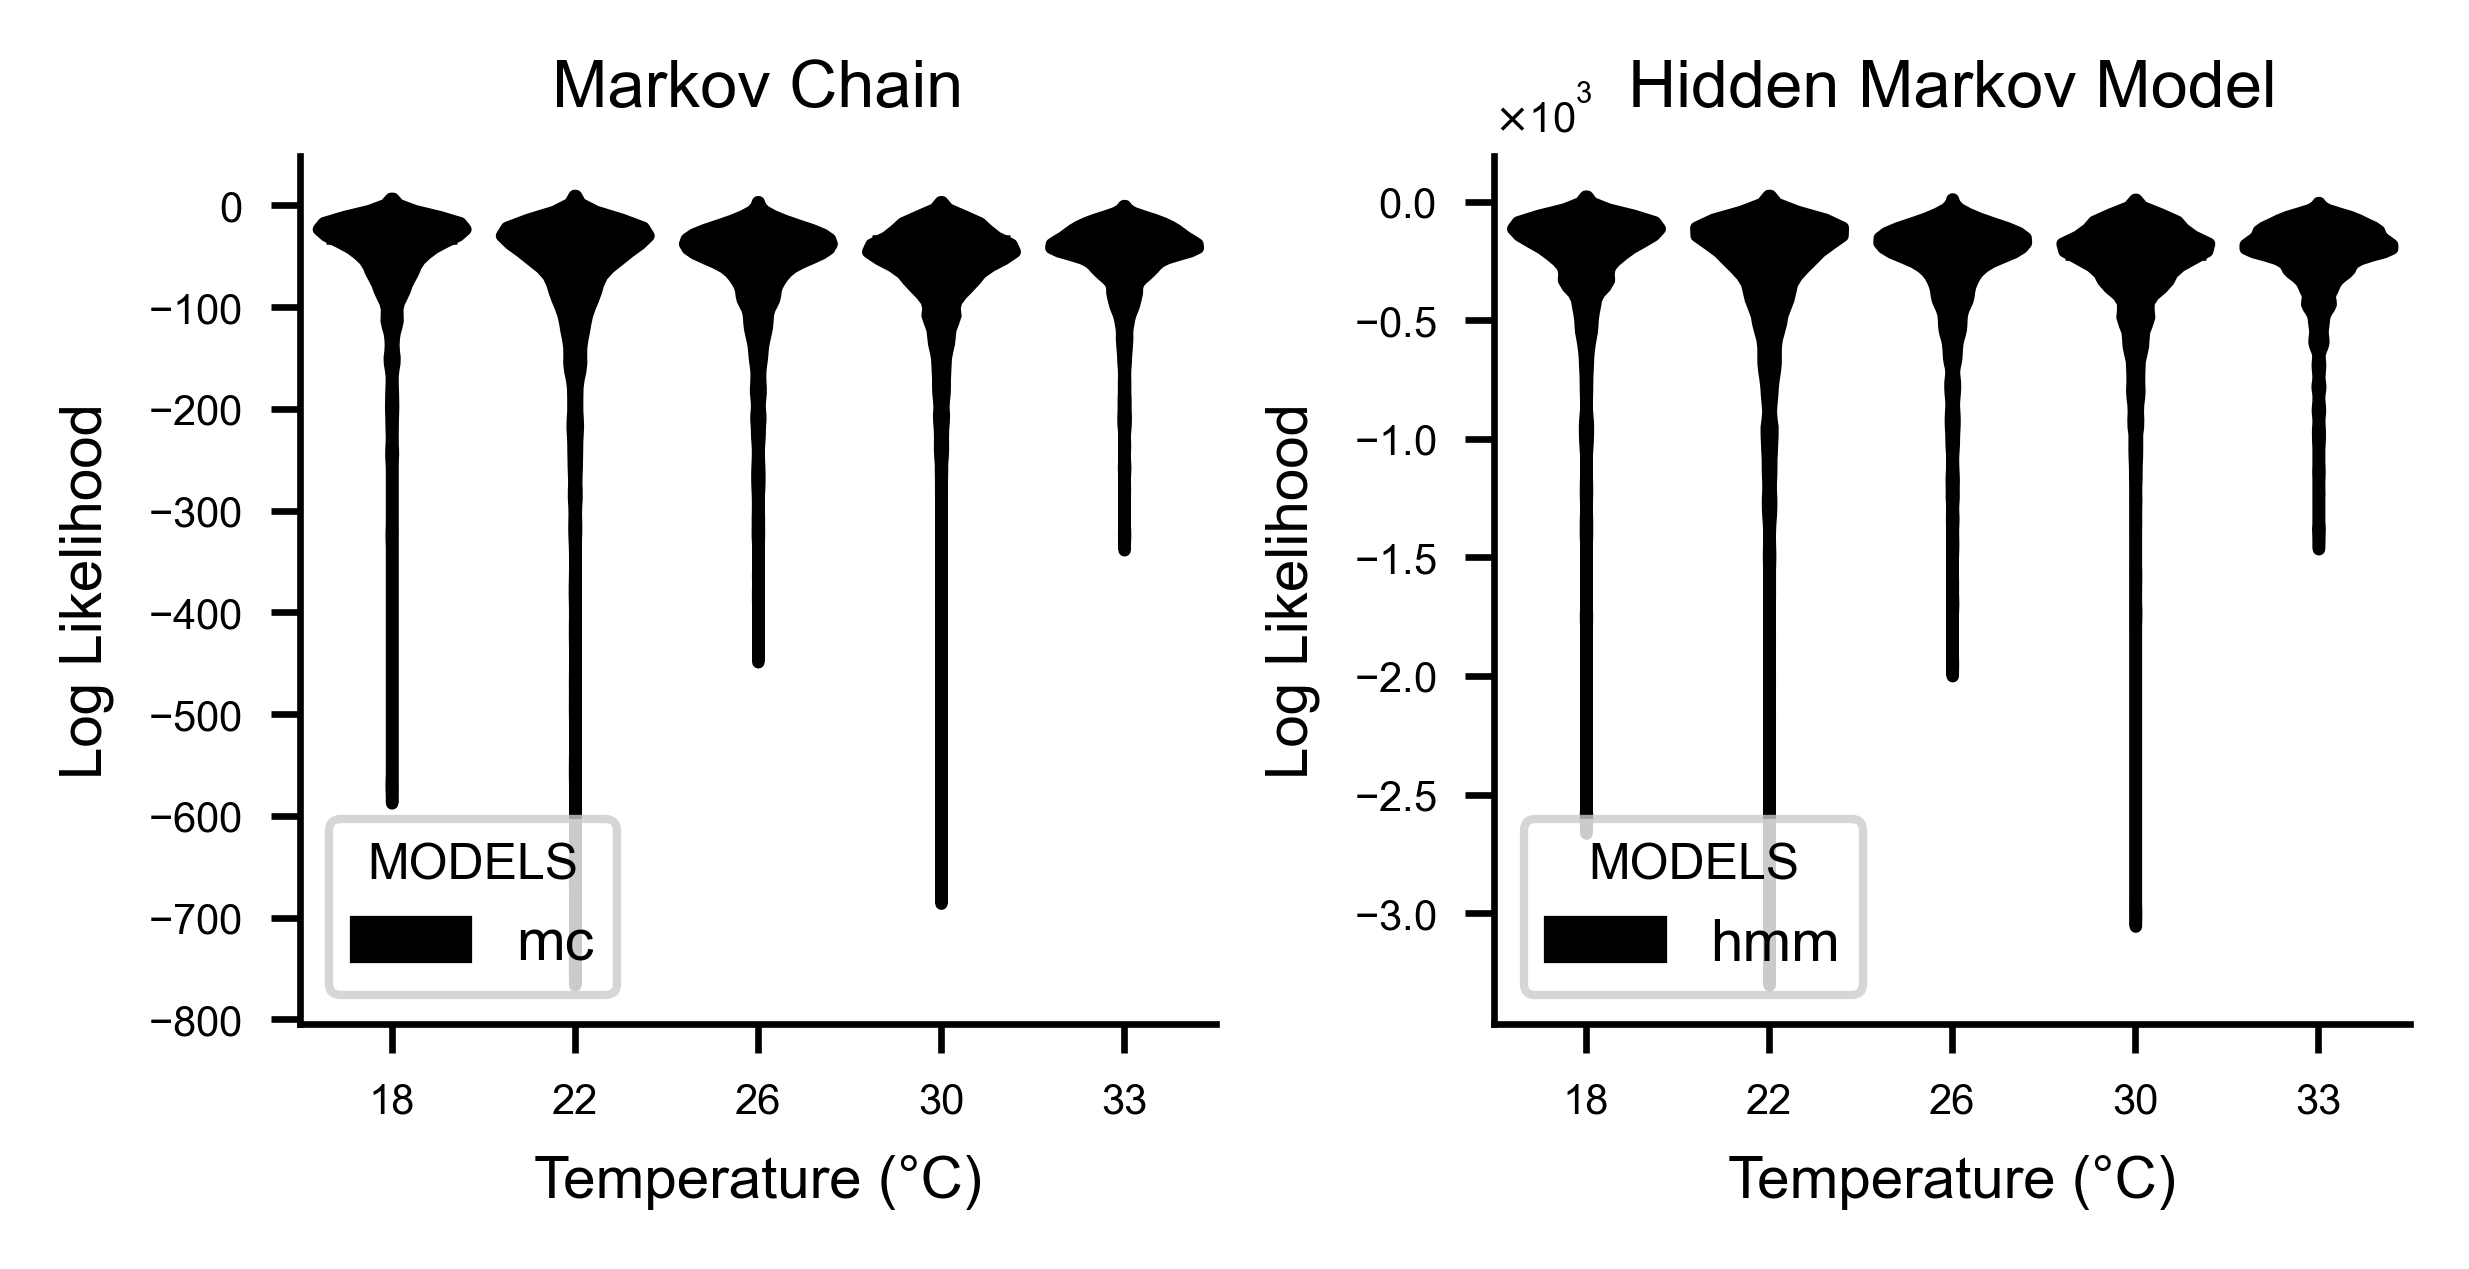

In [8]:
fig, axs = plt.subplots(ncols = 2, figsize=(2*2,2))

ax = axs[0]
ax.set_title("Markov Chain")
sns.violinplot(
        ax=ax,
        data=df[df["MODELS"]=="mc"], x="Temps", y="LLHs", hue="MODELS", 
        split=False, 
        inner="quart",
        density_norm="width",
        legend=False,
        #cut=0,
    )
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Log Likelihood")

ax = axs[1]
ax.set_title("Hidden Markov Model")
sns.violinplot(
        ax=ax,
        data=df[df["MODELS"]=="hmm"], x="Temps", y="LLHs", hue="MODELS", 
        split=False, 
        inner="quart",
        density_norm="width",
        legend=False,
        #cut=0,
    )
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Log Likelihood")

fig.savefig(f"panels/Fig2/supps/LLHs.svg")

## all transition matrices

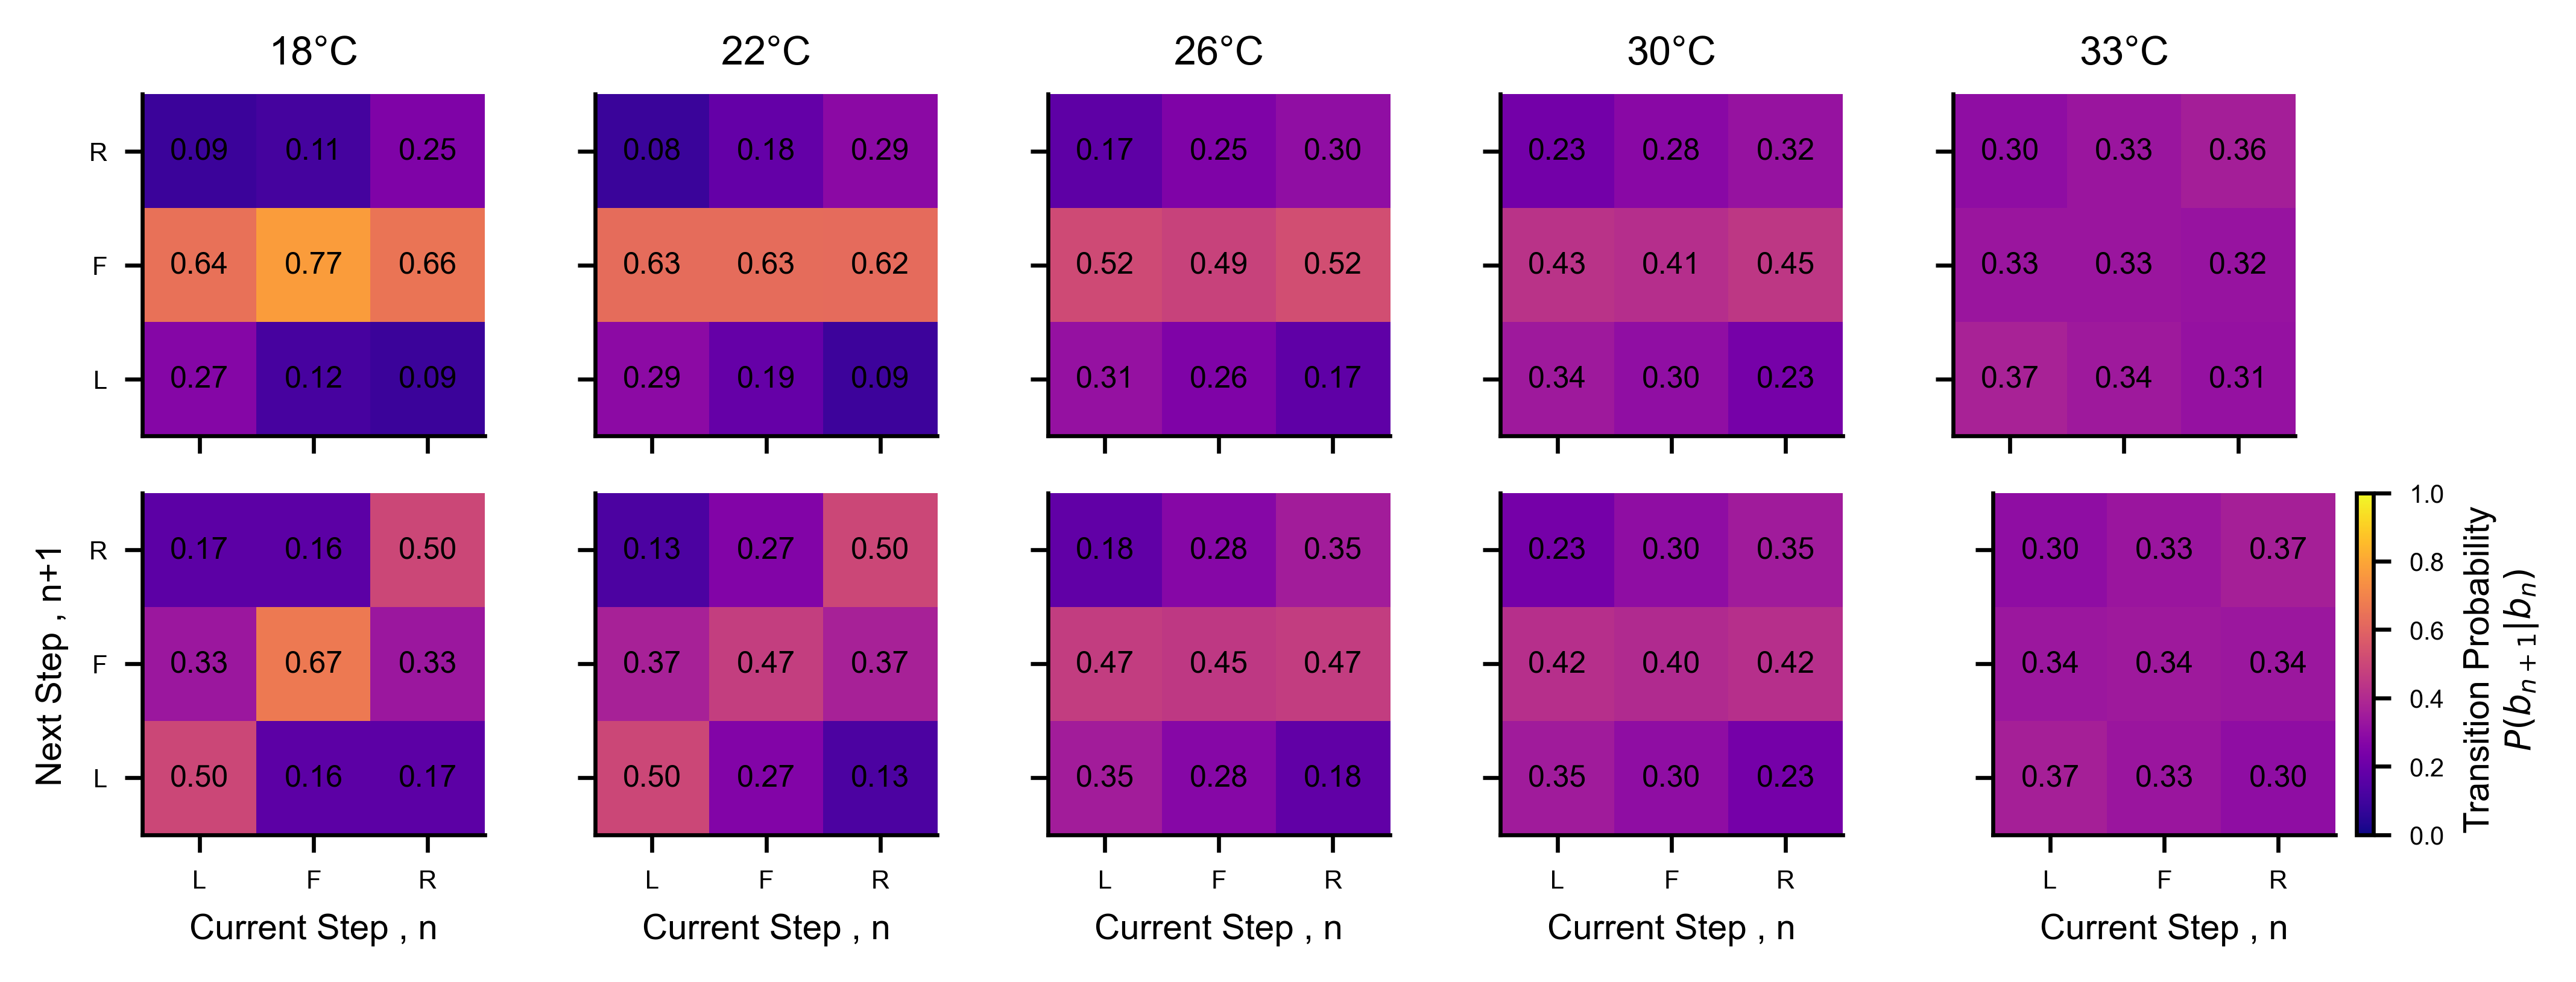

In [33]:
fig, axs = plt.subplots(nrows=2, ncols = len(TEMPS), figsize=(len(TEMPS)*1.4, 1.4 + 1.2), sharex=True, sharey=True)

for i, temp in enumerate(TEMPS):
    ax = axs[0,i]
    ax.set_title(f"{temp}°C")
    #X = file[f"/behaviour/{temp}/dtheta"][:]
    #X = format_sequences(X)
    X = load_sequences(bDATAPATH, temp)
    bouts = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    T = MC.bout_transitions(bouts, n_state=3)
    h = MC.plot_transition_matrix(ax, T[[1,0,2],:][:,[1,0,2]], labels=["L","F","R"], xlabel="Current Step , n", ylabel="Next Step , n+1")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax = axs[1,i]
    T = load_transmat(bMODELPATH, "g3", temp)
    h = MC.plot_transition_matrix(ax, T[[1,0,2],:][:,[1,0,2]], labels=["L","F","R"], xlabel="Current Step , n", ylabel="Next Step , n+1")
    if i > 0:
        ax.set_ylabel("")

fig.colorbar(h, ax=ax, label="Transition Probability \n"+r" $P(b_{n+1}|b_{n})$")

fig.savefig("panels/Fig2/supps/transitions_matrices.svg")

## Emission parameters

In [34]:
E_hmm = np.empty( (len(TEMPS), 3, 3) ) # ( temp x param x [alldataset, mean, std.err.mean] )
for t, temp in enumerate(TEMPS):
    E = load_emission(bMODELPATH, "g3", temp)
    E_hmm[t,0,0] = E["forward"]
    E_hmm[t,1:,0] = E["turn"]
    
    Es = load_emission_multi(bMODELPATH, "g3", temp)
    E_hmm[t,0,1] = Es["forward"].mean(axis=0)
    E_hmm[t,1:,1] = Es["turn"].mean(axis=0)
    E_hmm[t,0,2] = Es["forward"].ptp(axis=0)/2
    E_hmm[t,1:,2] = Es["turn"].ptp(axis=0)/2

/tmp/ipykernel_179247/3047055633.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hmm[t,0,0] = E["forward"]
/tmp/ipykernel_179247/3047055633.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hmm[t,0,1] = Es["forward"].mean(axis=0)
/tmp/ipykernel_179247/3047055633.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hmm[t,0,2] = Es["forward"].ptp(axis=0)/2


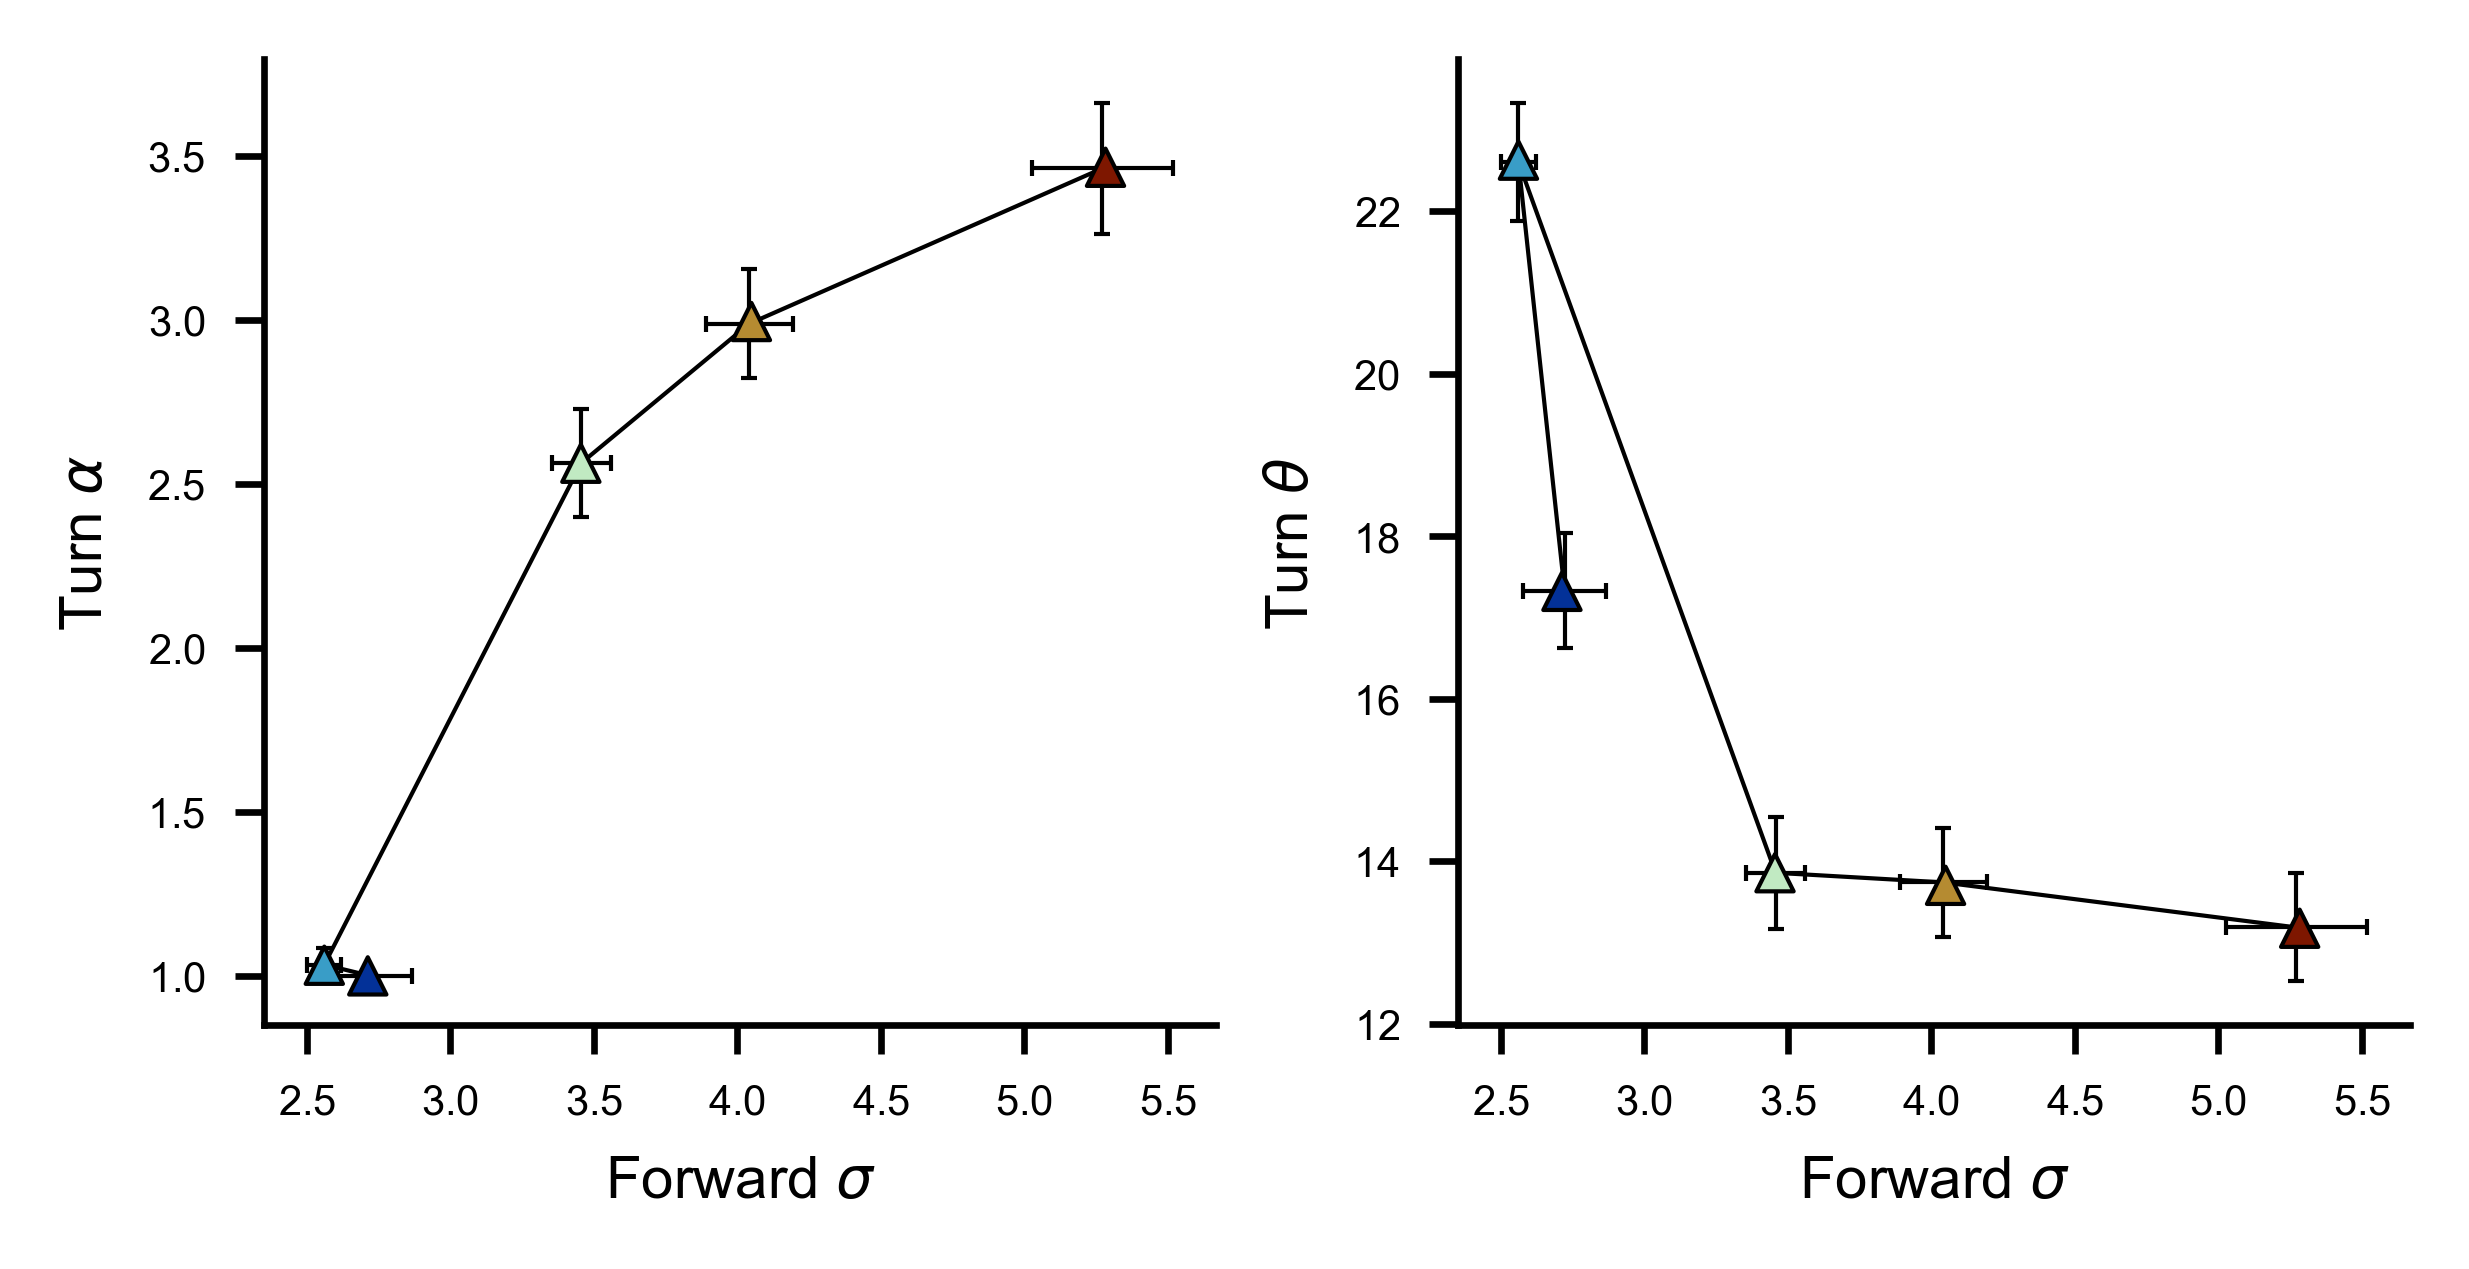

In [35]:
cols = list(TEMPS_COLS.values())

fig, axs = plt.subplots(ncols=2, figsize=(2*2,2))

ax = axs[0]
ax.scatter(E_hmm[:,0,0], E_hmm[:,1,0], c=cols,marker="^", s=20, edgecolor="black", linewidth=0.5, zorder=100)
ax.errorbar(E_hmm[:,0,1], E_hmm[:,1,1], xerr=E_hmm[:,0,2], yerr=E_hmm[:,1,2],markersize=1, capsize=1, linewidth=0.5, capthick=0.5)
ax.set_xlabel(r"Forward $\sigma$")
ax.set_ylabel(r"Turn $\alpha$")

ax = axs[1]
ax.scatter(E_hmm[:,0,0], E_hmm[:,2,0], c=cols, s=20, marker="^", edgecolor="black", linewidth=0.5, zorder=100)
ax.errorbar(E_hmm[:,0,1], E_hmm[:,2,1], xerr=E_hmm[:,0,2], yerr=E_hmm[:,2,2],markersize=1, capsize=1, linewidth=0.5, capthick=0.5)
ax.set_xlabel(r"Forward $\sigma$")
ax.set_ylabel(r"Turn $\theta$")

fig.savefig("panels/Fig2/supps/params_evolv.svg")

## Labeling distributions

In [36]:
from scipy.stats import gamma, norm

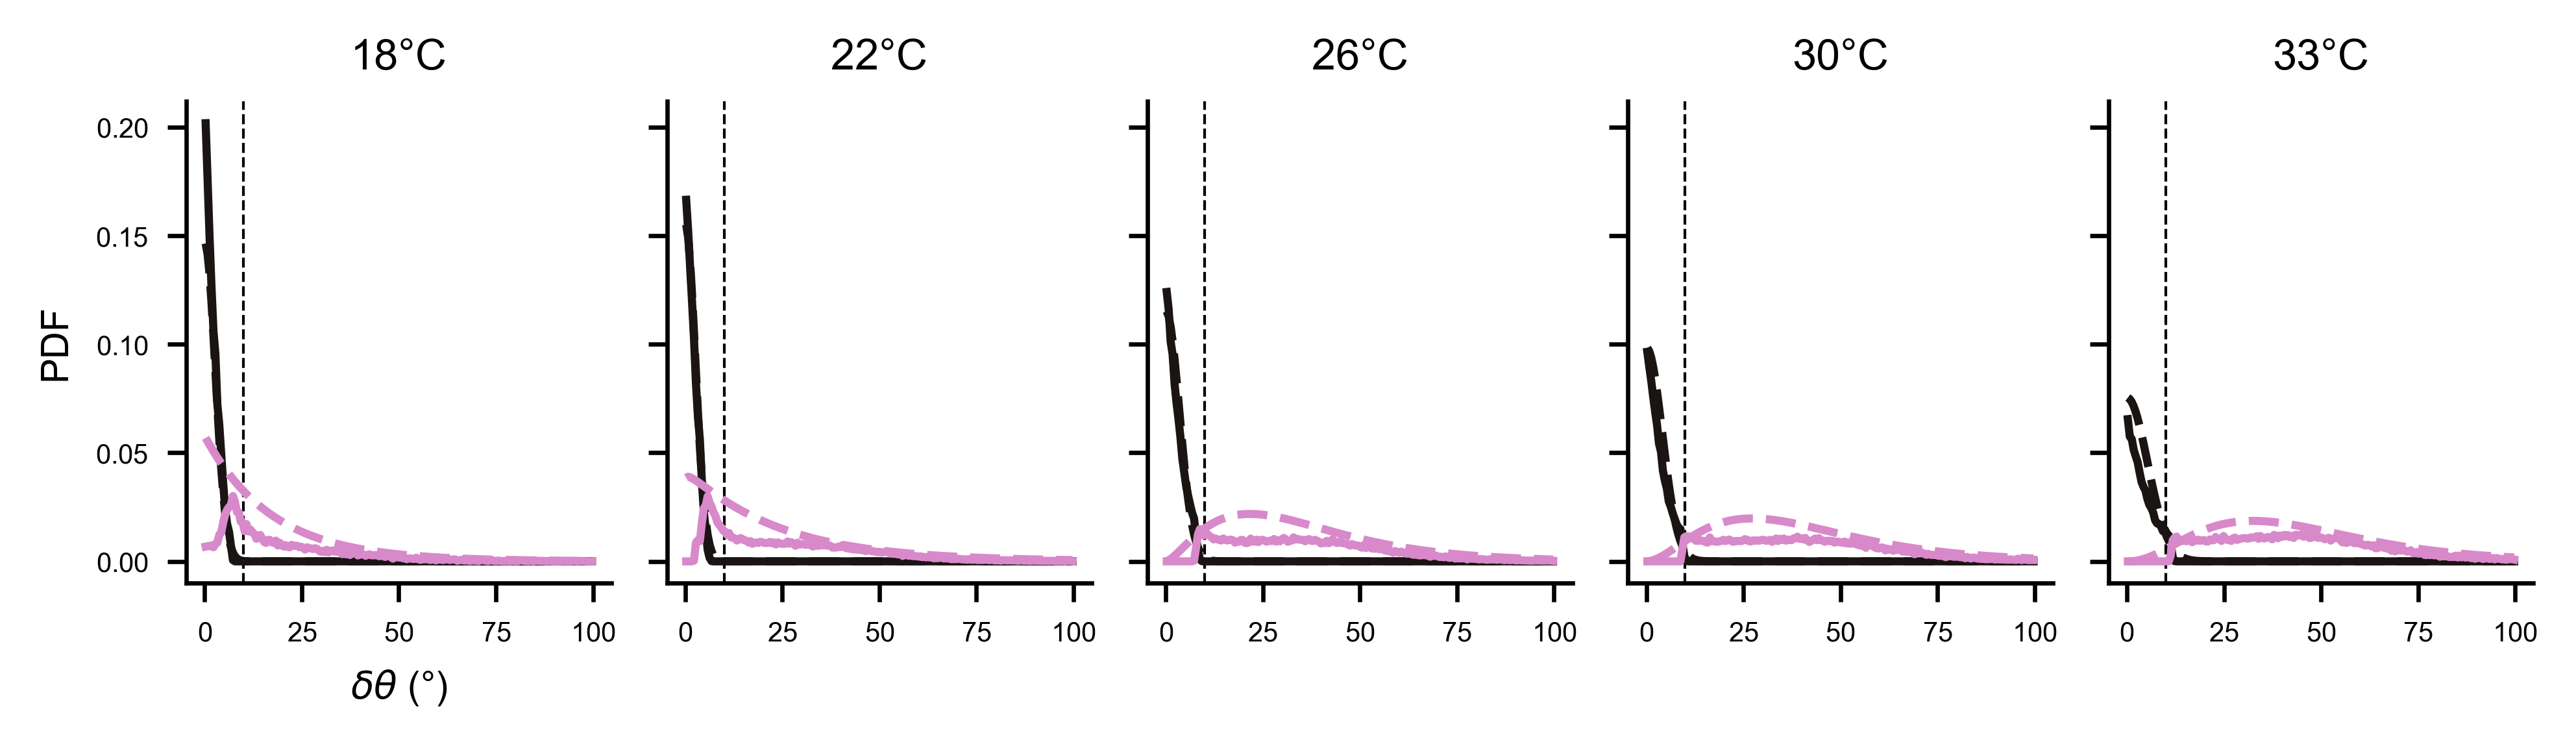

In [38]:
fig, axs = plt.subplots(ncols = len(TEMPS), figsize=(len(TEMPS)*1.3, 1.3 + 0.5), sharex=True, sharey=True)

bins = np.linspace(-0, +100, 200)
db = np.diff(bins).mean()
bin_centers = 0.5*(bins[1:] + bins[:-1])

for ax, temp in zip(axs, TEMPS):
    ax.set_title(f"{temp}°C")
    # get data labeling
    X = load_sequences(bDATAPATH, temp)
    X = np.abs(np.concatenate(X))
    bouts_hmm = np.concatenate(load_viterbi(bMODELPATH, "g3",temp))
    # get pdfs
    h, _ = np.histogram(X, bins)
    hf, _ = np.histogram(X[np.where(bouts_hmm == 0)[0]], bins)
    ht, _ = np.histogram(X[np.where((bouts_hmm == 1) + (bouts_hmm == 2))[0]], bins)
    nn = hf.sum() + ht.sum()
    hf = hf/nn / db
    ht = ht/nn / db
    h = h/h.sum() / db
    # get the PDFs from the model emissions
    params = load_emission(bMODELPATH, "g3", temp)
    F = norm.pdf(bin_centers, 0, params["forward"][0])
    T = gamma.pdf(bin_centers, params["turn"][0], scale=params["turn"][1])
    ax.plot(bin_centers, hf, color=FLR_colors[0], zorder=1)
    ax.plot(bin_centers, F, color=FLR_colors[0], linestyle="--", zorder=2)
    ax.plot(bin_centers, ht, color=FLR_colors[2], zorder=3)
    ax.plot(bin_centers, T, color=FLR_colors[2], linestyle="--", zorder=4)
    ax.axvline(DTHETA_THRESH, linestyle="--", linewidth=0.5, zorder=0)

axs[0].set_xlabel(r"$\delta \theta$ (°)")
axs[0].set_ylabel("PDF")

fig.savefig("panels/Fig2/supps/distrib_labelings.svg")

## Panel : P(b) vs Temp

In [43]:
# getting P(b) for Markov Chain from threhsolded data
n_rep = 100
frac = 0.5

P_BOUTS_mc = np.empty( (len(TEMPS), 3, 3) ) # ( temp x bout_type x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    X = load_sequences(bDATAPATH, temp)
    bouts = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    inds = np.arange(len(bouts))
    fracN = int(frac*len(bouts))
    Pb = []
    for r in range(n_rep):
        np.random.shuffle(inds)
        Pb.append(MC.bout_proba([bouts[i] for i in inds[:fracN]], n_state=3))
    Pb = np.c_[Pb]
    P_BOUTS_mc[t,:,1] = Pb.mean(axis=0)
    P_BOUTS_mc[t,:,2] = Pb.ptp(axis=0)/2
    P_BOUTS_mc[t,:,0] = MC.bout_proba(bouts)

In [44]:
# getting P(b) for HMM 3-state
P_BOUTS_hmm = np.empty( (len(TEMPS), 2, 3) ) # ( temp x bout_type x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    Ts = load_transmat_multi(bMODELPATH, "g3", temp)
    Pb = np.c_[[MC.steady_state(T) for T in Ts]]
    P_BOUTS_hmm[t,:,1] = Pb.mean(axis=0)[:2]
    P_BOUTS_hmm[t,:,2] = Pb.ptp(axis=0)[:2]/2
    T = load_transmat(bMODELPATH, "g3", temp)
    P_BOUTS_hmm[t,:,0] = MC.steady_state(T)[:2]

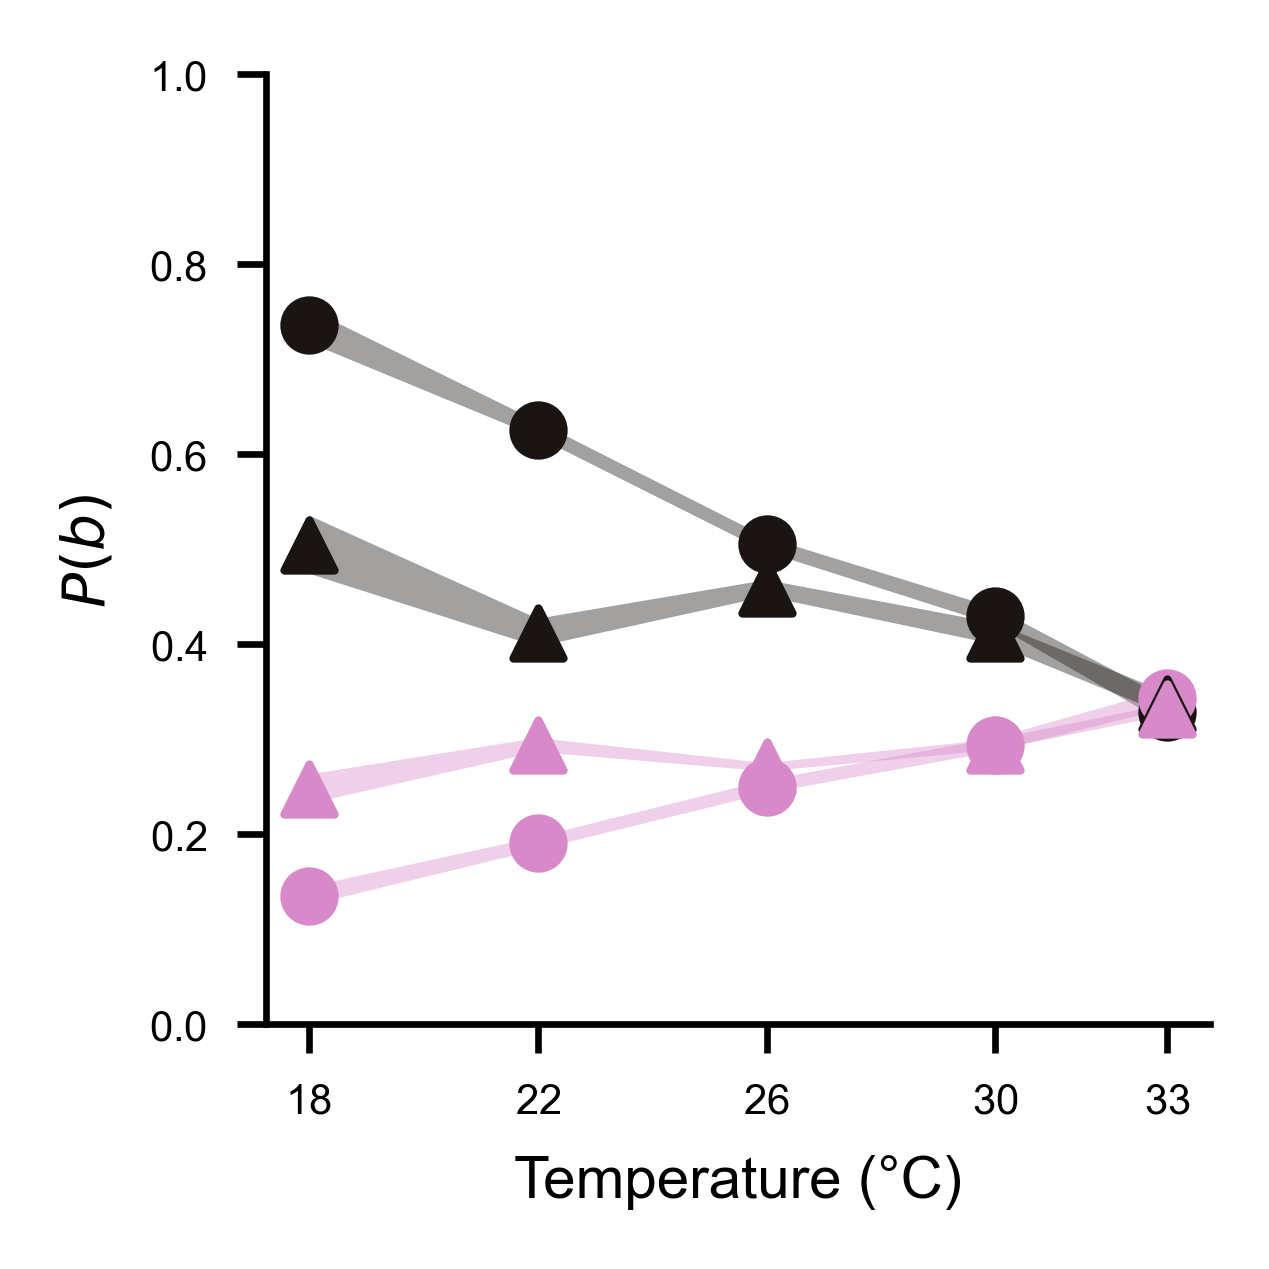

In [46]:
fig, ax = plt.subplots()

ax.scatter(TEMPS, P_BOUTS_mc[:,0,0], marker="o", color=FLR_colors[0],zorder=100)
ax.fill_between(
    TEMPS, 
    P_BOUTS_mc[:,0,1]+P_BOUTS_mc[:,0,2], 
    P_BOUTS_mc[:,0,1]-P_BOUTS_mc[:,0,2], 
    color=FLR_colors[0], edgecolor=None, alpha=0.4, zorder=0
)
ax.scatter(TEMPS, P_BOUTS_mc[:,1,0], marker="o", color=FLR_colors[2], zorder=100)
ax.fill_between(
    TEMPS, 
    P_BOUTS_mc[:,1,1]+P_BOUTS_mc[:,1,2], 
    P_BOUTS_mc[:,1,1]-P_BOUTS_mc[:,1,2], 
    color=FLR_colors[2], edgecolor=None, alpha=0.4, zorder=0
)

ax.scatter(TEMPS, P_BOUTS_hmm[:,0,0], marker="^", color=FLR_colors[0],zorder=101)
ax.fill_between(
    TEMPS, 
    P_BOUTS_hmm[:,0,1]+P_BOUTS_hmm[:,0,2], 
    P_BOUTS_hmm[:,0,1]-P_BOUTS_hmm[:,0,2], 
    color=FLR_colors[0], edgecolor=None, alpha=0.4, zorder=1
)
ax.scatter(TEMPS, P_BOUTS_hmm[:,1,0], marker="^", color=FLR_colors[2], zorder=101)
ax.fill_between(
    TEMPS, 
    P_BOUTS_hmm[:,1,1]+P_BOUTS_hmm[:,1,2], 
    P_BOUTS_hmm[:,1,1]-P_BOUTS_hmm[:,1,2], 
    color=FLR_colors[2], edgecolor=None, alpha=0.4, zorder=1
)

ax.set_ylim(0,1)
ax.set_xticks(TEMPS)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel(r"$P(b)$")
#ax.legend()

fig.savefig("panels/Fig2/supps/Pb.svg")

## P(n+1|n) vs Temp

In [39]:
# getting T for Markov Chain from threhsolded data
n_rep = 100
frac = 0.5

T_mc = np.empty( (len(TEMPS), 3, 3, 3) ) # ( temp x bn x bn+1 x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    X = load_sequences(bDATAPATH, temp)
    bouts = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)

    T_mc[t,:,:,0] = MC.bout_transitions(bouts)
    
    inds = np.arange(len(bouts))
    fracN = int(frac*len(bouts))
    Ts = []
    for r in range(n_rep):
        np.random.shuffle(inds)
        Ts.append(MC.bout_transitions([bouts[i] for i in inds[:fracN]], n_state=3))
    Ts = np.c_[Ts]
    T_mc[t,:,:,1] = Ts.mean(axis=0)
    T_mc[t,:,:,2] = Ts.ptp(axis=0)/2

In [40]:
# getting T for HMM 3-state
T_hmm = np.empty( (len(TEMPS), 3, 3, 3) ) # ( temp x bn x bn+1 x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    T_hmm[t,:,:,0] = load_transmat(bMODELPATH, "g3", temp)
    
    Ts = load_transmat_multi(bMODELPATH, "g3", temp)
    T_hmm[t,:,:,1] = Ts.mean(axis=0)
    T_hmm[t,:,:,2] = Ts.ptp(axis=0)/2

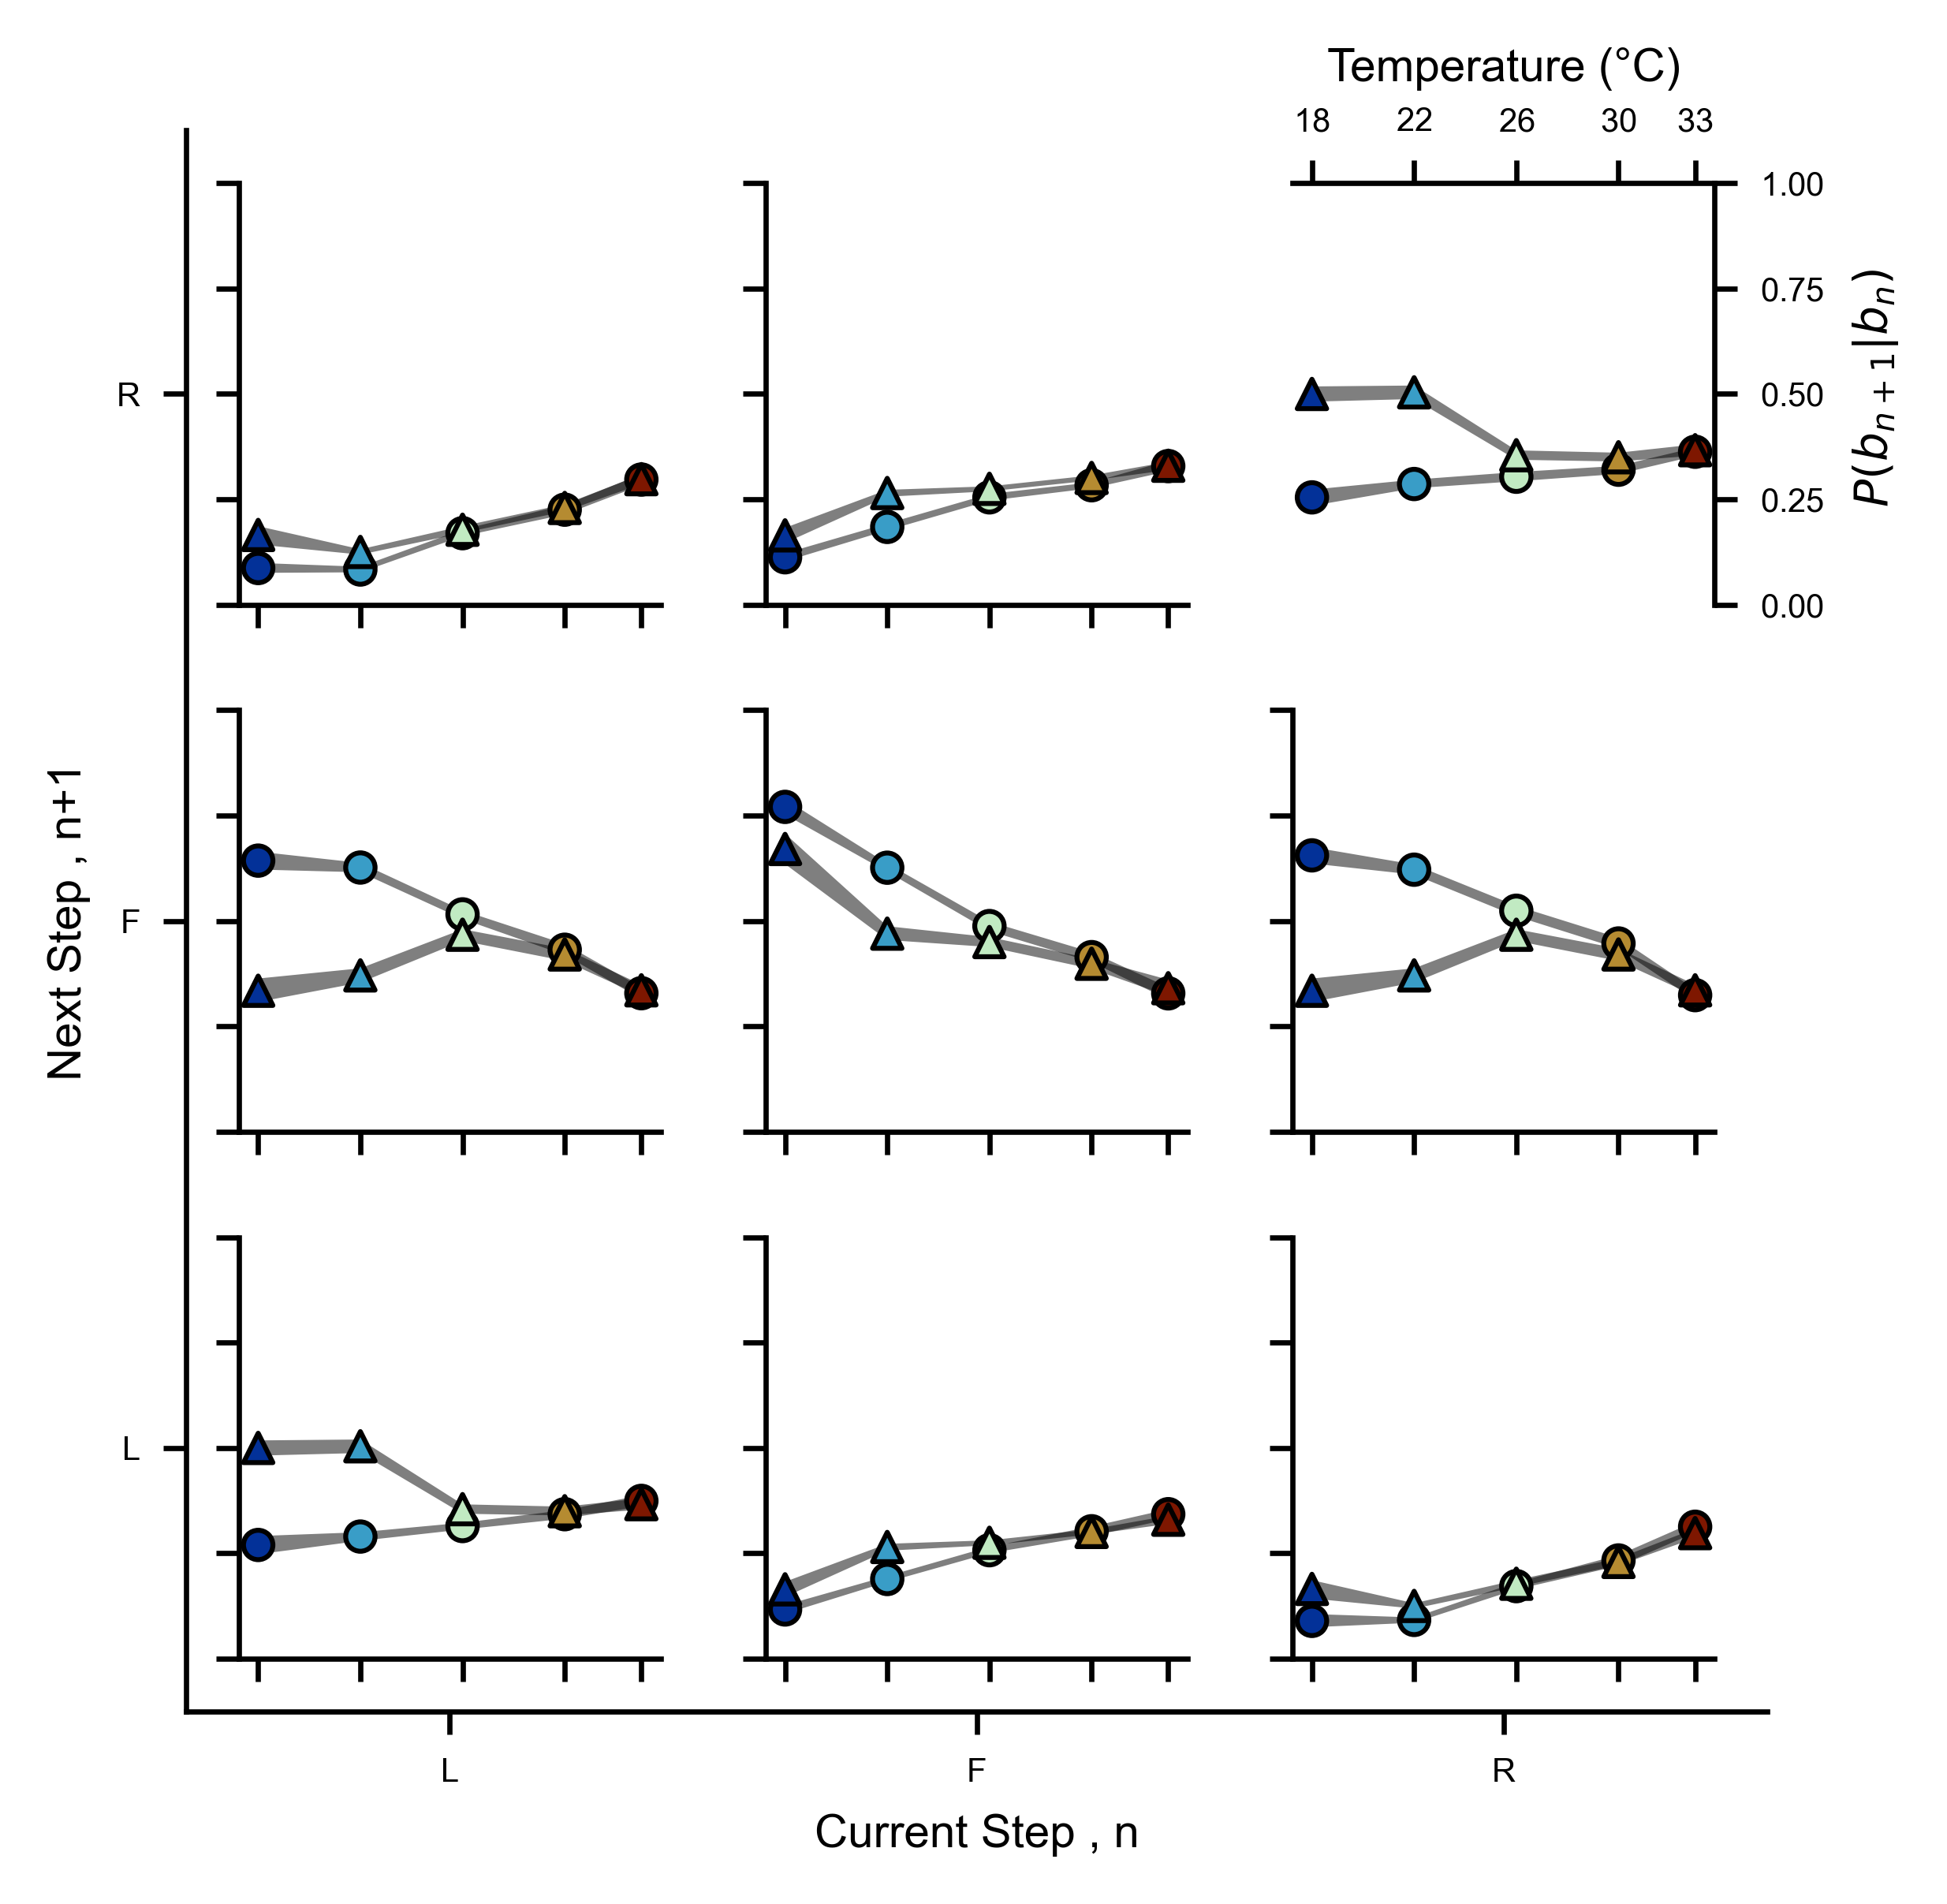

In [42]:
fig, ax = plt.subplots(figsize=(4,4))
pticks = np.linspace(0,1,5)
cols = list(TEMPS_COLS.values())
def center_f(a):
    if a == 0:
        return 1
    elif a == 1:
        return 0
    else:
        return a
        
for i in range(3):
    for j in range(3):
        axin = ax.inset_axes([center_f(i)-0.4, center_f(j)-0.4, 0.8, 0.8], transform=ax.transData)
        axin.set_xticks(TEMPS)
        axin.set_yticks(pticks)
        if (i,j) != (2,2):
            axin.set_xticklabels([])
            axin.set_yticklabels([])
        else:
            axin.set_xlabel("Temperature (°C)")
            axin.set_ylabel(r" $P(b_{n+1}|b_{n})$")
            axin.yaxis.tick_right()
            axin.yaxis.set_label_position("right")
            axin.spines['right'].set_visible(True)
            axin.spines['left'].set_visible(False)
            axin.xaxis.tick_top()
            axin.xaxis.set_label_position("top")
            axin.spines['top'].set_visible(True)
            axin.spines['bottom'].set_visible(False)
        axin.set_ylim(0,1)
        axin.scatter(TEMPS, T_mc[:,i,j,0],c=cols, s=20, edgecolor="black", marker="o", linewidth=0.75, zorder=100)
        axin.fill_between(TEMPS, T_mc[:,i,j,1]+T_mc[:,i,j,2], T_mc[:,i,j,1]-T_mc[:,i,j,2], alpha=0.5, zorder=0, color="k", edgecolor=None)
        axin.scatter(TEMPS, T_hmm[:,i,j,0],c=cols, s=20, edgecolor="black", marker="^", linewidth=0.75, zorder=100)
        axin.fill_between(TEMPS, T_hmm[:,i,j,1]+T_hmm[:,i,j,2], T_hmm[:,i,j,1]-T_hmm[:,i,j,2], alpha=0.5, zorder=0, color="k", edgecolor=None)
        
ax.set_xticks([0,1,2], ["L", "F", "R"])
ax.set_yticks([0,1,2], ["L", "F", "R"])
ax.set_xlabel("Current Step , n")
ax.set_ylabel("Next Step , n+1")
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.5,2.5)
ax.set_aspect("equal")

fig.savefig("panels/Fig2/supps/T.svg")

## Panel : all temperatures - all qs

In [54]:
COLORS = {
    "mc":"black",
    "hmm3":"orange",
    "gen":"purple",
}

In [52]:
qs = np.arange(8)

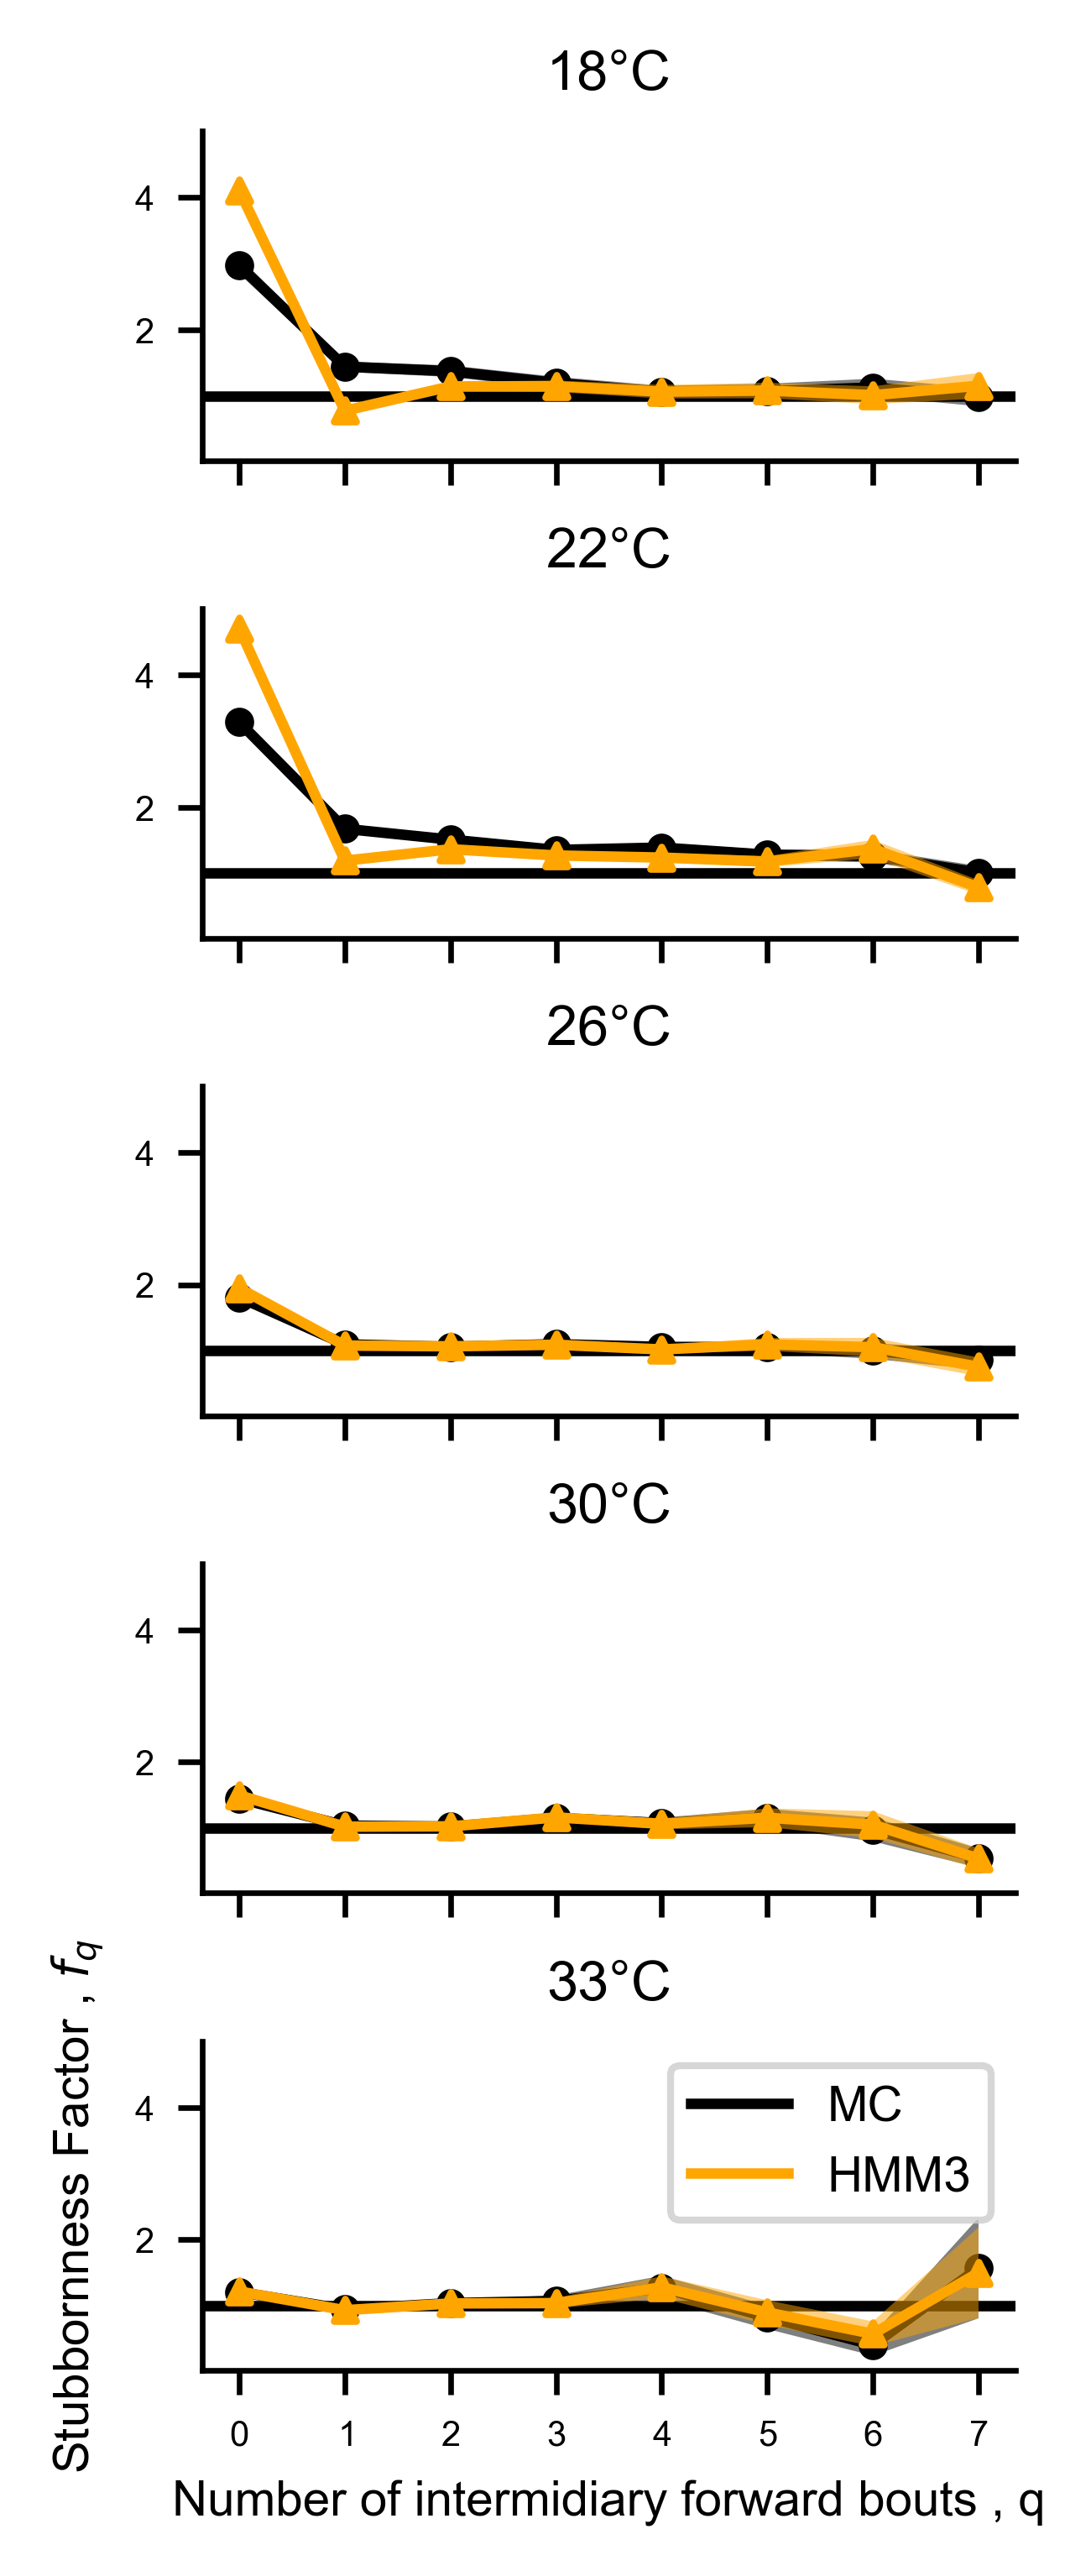

In [55]:
fig, axs = plt.subplots(nrows=len(TEMPS), figsize=(2*1,len(TEMPS)*1), sharex=True, sharey=True)
for ax, temp in zip(axs,TEMPS):
    Fs_mc, Fs_hmm3 = [], []
    for q in qs:
        seqs = MC.threshold_classifier(load_sequences(bDATAPATH, temp), -DTHETA_THRESH, +DTHETA_THRESH)
        centered = MC.center_bouts(seqs)
        Fs_mc.append(MC.stubbornness_factor(centered, q=q))
        seqs = load_viterbi(bMODELPATH, "g3", temp)
        centered = MC.center_bouts(seqs)
        Fs_hmm3.append(MC.stubbornness_factor(centered, q=q))
    Fs_mc = np.array(Fs_mc)
    Fs_hmm3 = np.array(Fs_hmm3)
    ax.scatter(qs, Fs_mc[:,0], marker="o", s=10, zorder=2, color=COLORS["mc"])
    ax.plot(qs, Fs_mc[:,0], zorder=1, color=COLORS["mc"], label="MC")
    ax.fill_between(qs, Fs_mc[:,0]-Fs_mc[:,1], Fs_mc[:,0]+Fs_mc[:,1], zorder=0, color=COLORS["mc"], alpha=0.5, edgecolor=None)

    ax.scatter(qs, Fs_hmm3[:,0], marker="^", s=10, zorder=5, color=COLORS["hmm3"])
    ax.plot(qs, Fs_hmm3[:,0], zorder=4, color=COLORS["hmm3"], label="HMM3")
    ax.fill_between(qs, Fs_hmm3[:,0]-Fs_hmm3[:,1], Fs_hmm3[:,0]+Fs_hmm3[:,1], zorder=3, color=COLORS["hmm3"], alpha=0.5, edgecolor=None)

    ax.axhline(1)
    ax.set_xticks(qs)
    ax.set_title(f"{temp}°C")

ax.set_xlabel("Number of intermidiary forward bouts , q")
ax.set_ylabel(r"Stubbornness Factor , $f_{q}$")
ax.legend()

fig.savefig("panels/Fig2/supps/Stubbs.svg")